In [2]:
import os

# IMPORTANT: Fix for PyTorch/IPython compatibility issue
# This must run BEFORE importing torch to avoid decorator conflicts
# This fixes the "disable() got an unexpected keyword argument 'wrapping'" error

# Method 1: Try to disable dynamo via environment variable (needs to be set before import)
os.environ.setdefault('TORCH_COMPILE_DISABLE', '1')

import torch

# Method 2: Patch torch._dynamo.disable decorator after import
try:
    import torch._dynamo
    # Patch the disable function to ignore the 'wrapping' parameter
    if hasattr(torch._dynamo, 'disable'):
        original_disable = torch._dynamo.disable
        def patched_disable(fn=None, *args, **kwargs):
            # Remove problematic 'wrapping' parameter if present
            if 'wrapping' in kwargs:
                kwargs.pop('wrapping')
            if fn is None:
                # Decorator usage: @disable
                return lambda f: f
            # Function usage: disable(fn) or disable(fn, **kwargs)
            try:
                return original_disable(fn, *args, **kwargs)
            except TypeError:
                # If original still fails, just return the function unwrapped
                return fn
        torch._dynamo.disable = patched_disable
except Exception as e:
    print(f"Warning: Could not patch torch._dynamo: {e}")
    pass  # If patching fails, continue anyway

import random, string

from torchtext import data , datasets
from collections import defaultdict, Counter
import numpy as np

os.environ['GENSIM_DATA_DIR'] = os.path.join(os.getcwd(), 'gensim-data')

import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_model

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import time

In [ ]:
### Part 0: Dataset Preparation

# For tokenization
TEXT = data.Field ( tokenize = 'spacy', tokenizer_language = 'en_core_web_sm', include_lengths = True )

# For multi - class classification labels
LABEL = data.LabelField ()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load the TREC dataset
# Train / Validation / Test split
train_data, test_data = datasets.TREC.splits( TEXT, LABEL, fine_grained = False )

train_data, validation_data = train_data.split(
    split_ratio=0.8,
    stratified=True,
    strata_field='label',
    random_state=42 ############################################################################################################################### check later
)
print(vars(train_data.examples[0]))


# Count how many samples per label in the train set
label_counts = Counter([ex.label for ex in train_data.examples])
total_examples = len(train_data)

print("\nLabel distribution in training set:")
for label, count in sorted(label_counts.items()):
    percentage = (count / total_examples) * 100
    print(f"- {label}: {count} samples ({percentage:.2f}%)")

# Optional sanity check: total percentages should sum ≈ 100%
total_percentage = sum((count / total_examples) * 100 for count in label_counts.values())
print(f"Total samples: {total_examples}, Sum of percentages: {total_percentage:.2f}%")


{'text': ['Where', 'did', 'the', 'real', 'St.', 'Nicholas', 'live', '?'], 'label': 'LOC'}

Label distribution in training set:
- ABBR: 69 samples (1.58%)
- DESC: 930 samples (21.32%)
- ENTY: 1000 samples (22.93%)
- HUM: 978 samples (22.42%)
- LOC: 668 samples (15.31%)
- NUM: 717 samples (16.44%)
Total samples: 4362, Sum of percentages: 100.00%


# Part 1: Prepare Word Embeddings

In [4]:
#### a) Size of Vocabulary formed from training data according to tokenization method
# Vocabulary size (includes specials like <unk>, <pad>)
TEXT.build_vocab(train_data, min_freq=1)
vocab_size = len(TEXT.vocab)
print("Vocabulary Size (with specials):", vocab_size)

vocab_wo_specials = len([w for w in TEXT.vocab.stoi if w not in {TEXT.unk_token, TEXT.pad_token}])
print("Vocabulary size (no specials):", vocab_wo_specials)

Vocabulary Size (with specials): 8188
Vocabulary size (no specials): 8186


In [5]:
#### b) How many OOV words exist in your training data?
####    What is the number of OOV words for each topic category?
# Load Word2Vec model from local file instead of downloading
# w2v = api.load('word2vec-google-news-300')
w2v = KeyedVectors.load('word2vec-google-news-300.model')
w2v_vocab = w2v.key_to_index

# Get training vocab tokens (types), excluding specials
specials = {TEXT.unk_token, TEXT.pad_token}
train_vocab_types = [w for w in TEXT.vocab.stoi.keys() if w not in specials]

# Overall OOV types in training vocab
oov_types_overall = {w for w in train_vocab_types if w not in w2v_vocab}
print("Number of OOV word types (overall):", len(oov_types_overall))

# OOV types per label (unique types per category across its sentences)
label_to_oov_types = defaultdict(set)
label_to_total_types = defaultdict(set)

for ex in train_data.examples:
    label = ex.label
    # Count by unique types per sentence to avoid overcounting repeats
    for w in set(ex.text):
        label_to_total_types[label].add(w)
        if w not in specials and w not in w2v_vocab:
            label_to_oov_types[label].add(w)

print("\nOOV word types per topic label:")
for label in sorted(label_to_total_types.keys()):
    num_oov = len(label_to_oov_types[label])
    num_types = len(label_to_total_types[label])
    rate = (num_oov / num_types) if num_types > 0 else 0.0
    print(f"- {label}: {num_oov} OOV types (out of {num_types}, rate={rate:.2%})")

Number of OOV word types (overall): 408

OOV word types per topic label:
- ABBR: 18 OOV types (out of 155, rate=11.61%)
- DESC: 117 OOV types (out of 2308, rate=5.07%)
- ENTY: 145 OOV types (out of 3002, rate=4.83%)
- HUM: 137 OOV types (out of 3078, rate=4.45%)
- LOC: 74 OOV types (out of 1752, rate=4.22%)
- NUM: 84 OOV types (out of 1892, rate=4.44%)


In [6]:
# #### c) OOV mitigation strategy (No transformer-based language models allowed)
# Implement your solution in your source code. Show the corresponding code snippet.
# 1. Fast Text Model Implementatation
# Load FastText with subword info (pretrained on Wikipedia)
# First download is large; cached afterwards

# 2. Modelling Unknown (<UNK>) token approach
# Make the <unk> vector informative and trainable by initializing it
# as the mean of available pretrained vectors.

# Loading fasttext model
fatter_fasttext_bin = load_facebook_model('crawl-300d-2M-subword/crawl-300d-2M-subword.bin')
embedding_dim = fatter_fasttext_bin.wv.vector_size

# Build embedding matrix aligned to TEXT.vocab
num_tokens = len(TEXT.vocab)
emb_matrix = np.zeros((num_tokens, embedding_dim), dtype=np.float32)

# torchtext 0.4.0: TEXT.vocab.itos is index->token, stoi is token->index
pad_tok = TEXT.pad_token
unk_tok = TEXT.unk_token

# Getting index of <unk> in vocab
unk_index = TEXT.vocab.stoi[TEXT.unk_token]
known_vecs = []

for idx, token in enumerate(TEXT.vocab.itos):
    # Skip specials here; we will set them explicitly below
    if token in {pad_tok, unk_tok}:
        continue

    vec = fatter_fasttext_bin.wv[token]
    emb_matrix[idx] = vec
    known_vecs.append(vec)

if len(known_vecs) > 0:
    unk_mean = torch.tensor(np.mean(known_vecs, axis=0), dtype=torch.float32)
else:
    unk_mean = torch.empty(embedding_dim).uniform_(-0.05, 0.05)
with torch.no_grad():
    emb_matrix[unk_index] = unk_mean

# Create Embedding layer initialized with FastText
fatter_embedding = torch.nn.Embedding(num_tokens, embedding_dim, padding_idx=TEXT.vocab.stoi[TEXT.pad_token])
fatter_embedding.weight.data.copy_(torch.from_numpy(emb_matrix))

torch.save(fatter_embedding, 'embedding_weights_fatter_fasttext.pt')

In [7]:
#### d) Select the 20 most frequent words from each topic category in the training set (removing
# stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).
# Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).
# Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here.
# Analyze your findings.

# Build per-label token frequency (lowercased, stopwords/punct filtered)
label_to_counter = defaultdict(Counter)
valid_chars = set(string.ascii_letters)

def is_valid_token(tok: str) -> bool:
    t = tok.strip("'\"")
    if len(t) == 0:
        return False
    # Keep purely alphabetic tokens to avoid punctuation/numbers
    return t.isalpha()

for ex in train_data.examples:
    label = ex.label
    for tok in ex.text:
        tok_l = tok.lower()
        if tok_l in STOP_WORDS:
            continue
        if not is_valid_token(tok_l):
            continue
        label_to_counter[label][tok_l] += 1

# Select top 20 per label that exist in Word2Vec
topk = 20
label_to_top_tokens = {}
for label, ctr in label_to_counter.items():
    selected = []
    for tok, _ in ctr.most_common():
        if tok in w2v.key_to_index:
            selected.append(tok)
        if len(selected) >= topk:
            break
    label_to_top_tokens[label] = selected

# Collect embeddings and labels
points = []
point_labels = []
point_words = []
for label, toks in label_to_top_tokens.items():
    for tok in toks:
        vec = w2v.get_vector(tok)
        points.append(vec)
        point_labels.append(label)
        point_words.append(tok)

if len(points) > 0:
    X = np.vstack(points)

    # 2D projections
    tsne_2d = TSNE(n_components=2, random_state=42, init="pca", perplexity=30).fit_transform(X)
    pca_2d = PCA(n_components=2, random_state=42).fit_transform(X)

    # Assign colors per label
    unique_labels = sorted(set(point_labels))
    color_map = {lab: plt.cm.tab10(i % 10) for i, lab in enumerate(unique_labels)}

    def plot_scatter(Y2, title: str, fname: str):
        plt.figure(figsize=(10, 8))
        for lab in unique_labels:
            idxs = [i for i, l in enumerate(point_labels) if l == lab]
            plt.scatter(Y2[idxs, 0], Y2[idxs, 1], c=[color_map[lab]], label=lab, alpha=0.8, s=40)
            # Light word annotations (optional; can clutter)
            for i in idxs:
                plt.annotate(point_words[i], (Y2[i, 0], Y2[i, 1]), fontsize=7, alpha=0.7)
        plt.legend(title="TREC label")
        plt.title(title)
        plt.tight_layout()
        plt.savefig(fname, dpi=200)
        plt.close()

    plot_scatter(tsne_2d, "Top-20 per TREC label (Word2Vec) - t-SNE", "trec_top20_tsne.png")
    plot_scatter(pca_2d, "Top-20 per TREC label (Word2Vec) - PCA", "trec_top20_pca.png")

    print("Saved plots: trec_top20_tsne.png, trec_top20_pca.png")
    for lab in unique_labels:
        print(f"{lab}: {label_to_top_tokens[lab]}")
else:
    print("No points collected for visualization. Check filtering or embedding availability.")

Saved plots: trec_top20_tsne.png, trec_top20_pca.png
ABBR: ['stand', 'abbreviation', 'mean', 'acronym', 'cpr', 'letters', 'national', 'bureau', 'investigation', 'e', 'general', 'motors', 'cnn', 'abbreviated', 'zip', 'equation', 'trinitrotoluene', 'deet', 'dsl', 'limited']
DESC: ['mean', 'origin', 'difference', 'find', 'word', 'come', 'causes', 'work', 'meaning', 'term', 'people', 'like', 't', 'history', 'makes', 'time', 'water', 'happened', 'definition', 'school']
ENTY: ['fear', 'kind', 'called', 'world', 'film', 'color', 'animal', 'movie', 'war', 'novel', 'tv', 'best', 'book', 'term', 'play', 'english', 'sport', 'drink', 'game', 'use']
HUM: ['president', 'company', 'wrote', 'world', 'famous', 'invented', 'won', 'baseball', 'star', 'tv', 'actor', 'team', 'movie', 'new', 'played', 'said', 'american', 'actress', 'character', 'portrayed']
LOC: ['country', 'city', 'state', 'world', 'find', 'largest', 'located', 'river', 'countries', 'highest', 'live', 'capital', 'american', 'mountain', 'st

In [8]:
fasttext = torch.load('embedding_weights_fatter_fasttext.pt', weights_only=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
### Part 2: Model Training & Evaluation - RNN

# Build vocabulary for labels
LABEL.build_vocab(train_data)
num_classes = len(LABEL.vocab)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {LABEL.vocab.itos}")

# Create iterators for batching (inline for easier debugging)
# train_iterator = data.BucketIterator(...)
# val_iterator = data.BucketIterator(...)
# test_iterator = data.BucketIterator(...)
# (Used directly in Part 2 execution below)


class SimpleRNNClassifier(nn.Module):
    """
    Simple RNN for topic classification (Baseline - no dropout).
    Uses pretrained embeddings (learnable/updated during training) with OOV mitigation 
    and aggregates word representations to sentence representation using the last hidden state.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=1, dropout=0.0, padding_idx=0, pretrained_embeddings=None):
        super(SimpleRNNClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # IMPORTANT: Make embeddings learnable (updated during training)
            # This allows fine-tuning of embeddings including OOV words handled by FastText
            self.embedding.weight.requires_grad = True
        
        # Simple RNN layer (no dropout in baseline)
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.0  # No dropout in baseline
        )
        
        # Removed: Dropout layer (baseline has no regularization)
        # self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Get dimensions
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths: ensure it's a 1D tensor with batch_size elements
        text_lengths_flat = text_lengths.flatten().cpu().long()
        
        # text_lengths should have exactly batch_size elements (one length per batch item)
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, "
                f"expected {batch_size} (batch_size). text_lengths.shape={text_lengths.shape}, "
                f"text.shape={text.shape}, embedded.shape={embedded.shape}"
            )
        
        # Clamp lengths to be at most the sequence length (safety check)
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        
        # Pack the padded sequences for efficient processing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through RNN
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden: [n_layers, batch_size, hidden_dim]
        
        # Use the last hidden state from the last layer
        last_hidden = hidden[-1]  # [batch_size, hidden_dim]
        
        # Removed: Apply dropout (baseline has no regularization)
        # last_hidden = self.dropout(last_hidden)
        
        # Pass through fully connected layer
        output = self.fc(last_hidden)  # [batch_size, output_dim]
        
        return output


# Utility function for counting parameters
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training and evaluation functions removed - code is now inline below for easier debugging


Number of classes: 6
Classes: ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']


In [11]:
print(len(TEXT.vocab))

8188


Training order:
1. Word aggregation
2. Hyperparameters tuning
3. Regularization

In [12]:
# ============================================================================
# Part 2: Initial Simple RNN Model Training
# ============================================================================

print("\n" + "="*80)
print("PART 2: SIMPLE RNN MODEL TRAINING")
print("="*80)

# Get pretrained embeddings from Part 1 (frozen embeddings)
pretrained_embeddings = fasttext.weight.data

# Get embedding dimension and vocab size from the fasttext embedding layer
embedding_dim = fasttext.weight.shape[1]
fasttext_vocab_size = fasttext.weight.shape[0]  # Vocab size from saved embedding

# Verify vocab sizes match (they might differ if vocab was rebuilt)
print(f"TEXT.vocab size: {len(TEXT.vocab)}")
print(f"FastText embedding vocab size: {fasttext_vocab_size}")

# Hyperparameters
BATCH_SIZE = 64
HIDDEN_DIM = 256
N_LAYERS = 1
DROPOUT = 0.0  # Baseline: no dropout
N_EPOCHS = 100
LEARNING_RATE = 0.001
# Removed: PATIENCE = 10  # Baseline: no early stopping

# Create data iterators (inline for easier debugging)
# Note: Different sequence lengths per batch are normal - BucketIterator groups similar-length sequences
train_iterator = data.BucketIterator(
    train_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,  # Shuffle for training
    device=device
)

val_iterator = data.BucketIterator(
    validation_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,  # No shuffle for validation (deterministic)
    device=device
)

test_iterator = data.BucketIterator(
    test_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,  # No shuffle for test (deterministic)
    device=device
)

# Initialize simple RNN model (Baseline)
# Use vocab size from loaded embedding to match the saved weights exactly
model = SimpleRNNClassifier(
    vocab_size=fasttext_vocab_size,  # Must match saved embedding vocab size
    embedding_dim=embedding_dim,
    hidden_dim=HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=0.0,  # Baseline: no dropout
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\n>>> Training Baseline RNN Model")
print(f"Configuration:")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Layers: {N_LAYERS}")
print(f"  - Dropout: {DROPOUT} (Baseline: no regularization)")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {N_EPOCHS} (no early stopping)")
print(f"  - Embedding Dim: {embedding_dim} (FastText)")
print(f"  - Embeddings: LEARNABLE (updated during training)")
print(f"  - OOV Handling: FastText subword embeddings + trainable <unk> token")

# ============================================================================
# Helper function to process batches consistently
# ============================================================================

def process_batch(batch, debug=False):
    """
    Process a batch from BucketIterator, handling text transpose correctly.
    Returns: text, text_lengths, labels (all properly formatted)
    """
    text, text_lengths = batch.text
    labels = batch.label
    
    if debug:
        print(f"DEBUG BATCH - text shape: {text.shape}, text_lengths shape: {text_lengths.shape}, labels shape: {labels.shape}")
    
    # torchtext BucketIterator returns text as [seq_len, batch_size] by default
    # We need [batch_size, seq_len] for batch_first=True in the model
    expected_batch_size = labels.shape[0]
    
    if text.dim() == 2:
        if text.shape[1] == expected_batch_size and len(text_lengths) == expected_batch_size:
            # text is [seq_len, batch_size], transpose to [batch_size, seq_len]
            text = text.transpose(0, 1)
            if debug:
                print(f"DEBUG BATCH - Transposed text to [batch_size, seq_len]: {text.shape}")
        elif text.shape[0] == expected_batch_size and len(text_lengths) == expected_batch_size:
            # text is already [batch_size, seq_len]
            if debug:
                print(f"DEBUG BATCH - text already in correct format: {text.shape}")
        else:
            raise ValueError(
                f"Cannot determine text format: text.shape={text.shape}, "
                f"text_lengths.shape={text_lengths.shape}, labels.shape={labels.shape}"
            )
    
    # Verify dimensions match
    assert text.shape[0] == len(text_lengths) == labels.shape[0], \
        f"Batch size mismatch: text.shape[0]={text.shape[0]}, len(text_lengths)={len(text_lengths)}, labels.shape[0]={labels.shape[0]}"
    
    return text, text_lengths, labels

# Set seeds for reproducibility
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Note: PyTorch/IPython compatibility fix is already applied in cell 0
# The torch._dynamo.disable decorator has been patched to handle the 'wrapping' parameter

# ============================================================================
# Training Loop (inline for easier debugging)
# ============================================================================

best_val_acc = 0
# Removed: patience_counter = 0  # Baseline: no early stopping

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"\nStarting training for {N_EPOCHS} epochs...")  # Removed "up to" - no early stopping
print(f"Device: {device}")
print(f"Trainable parameters: {count_parameters(model):,}")
print(f"Embedding layer learnable: {model.embedding.weight.requires_grad}")
# Removed: print(f"Early stopping patience: {PATIENCE} epochs")  # Baseline: no early stopping
print("-" * 80)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    # ========================================================================
    # Training for one epoch (inline)
    # ========================================================================
    model.train()
    train_epoch_loss = 0
    train_all_preds = []
    train_all_labels = []
    
    batch_idx = 0
    for batch in train_iterator:
        # Process batch (with debug only for first batch)
        text, text_lengths, labels = process_batch(batch, debug=(batch_idx == 0))
        batch_idx += 1
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        
        # Removed: Gradient clipping (baseline has no gradient clipping)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update weights
        optimizer.step()
        
        train_epoch_loss += loss.item()
        
        # Store predictions and labels for metrics
        preds = torch.argmax(predictions, dim=1)
        train_all_preds.extend(preds.cpu().numpy())
        train_all_labels.extend(labels.cpu().numpy())
    
    # Calculate training accuracy
    train_acc = accuracy_score(train_all_labels, train_all_preds)
    train_loss = train_epoch_loss / len(train_iterator)
    
    # ========================================================================
    # Validation evaluation (inline)
    # ========================================================================
    model.eval()
    val_epoch_loss = 0
    val_all_preds = []
    val_all_labels = []
    
    with torch.no_grad():
        for batch in val_iterator:
            # Process batch consistently with training
            text, text_lengths, labels = process_batch(batch, debug=False)
            
            # Forward pass
            predictions = model(text, text_lengths)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            val_epoch_loss += loss.item()
            
            # Store predictions and labels
            preds = torch.argmax(predictions, dim=1)
            val_all_preds.extend(preds.cpu().numpy())
            val_all_labels.extend(labels.cpu().numpy())
    
    # Calculate validation accuracy
    val_acc = accuracy_score(val_all_labels, val_all_preds)
    val_loss = val_epoch_loss / len(val_iterator)
    
    # ========================================================================
    # Logging (without early stopping)
    # ========================================================================
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch: {epoch+1:02}/{N_EPOCHS} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')
    
    # Track best model (but don't stop early - baseline trains for all epochs)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save best model
        torch.save(model.state_dict(), 'rnn_simple_best.pt')
        print(f'\t>>> New best model saved with Val Acc: {val_acc*100:.2f}%')
    # Removed: Early stopping break logic (baseline trains for all epochs)

print("-" * 80)
print(f"Training completed! Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Total epochs trained: {N_EPOCHS}")


PART 2: SIMPLE RNN MODEL TRAINING
TEXT.vocab size: 8188
FastText embedding vocab size: 8188

>>> Training Baseline RNN Model
Configuration:
  - Hidden Dim: 256
  - Layers: 1
  - Dropout: 0.0 (Baseline: no regularization)
  - Learning Rate: 0.001
  - Batch Size: 64
  - Epochs: 100 (no early stopping)
  - Embedding Dim: 300 (FastText)
  - Embeddings: LEARNABLE (updated during training)
  - OOV Handling: FastText subword embeddings + trainable <unk> token

Starting training for 100 epochs...
Device: cuda
Trainable parameters: 2,600,790
Embedding layer learnable: True
--------------------------------------------------------------------------------
DEBUG BATCH - text shape: torch.Size([8, 64]), text_lengths shape: torch.Size([64]), labels shape: torch.Size([64])
DEBUG BATCH - Transposed text to [batch_size, seq_len]: torch.Size([64, 8])
Epoch: 01/100 | Time: 0m 5s
	Train Loss: 1.5944 | Train Acc: 28.06%
	Val Loss: 1.5010 | Val Acc: 33.49%
	>>> New best model saved with Val Acc: 33.49%
DEBU

In [13]:
# ============================================================================
# Validation Set Evaluation (inline) - Evaluate best model on validation set
# ============================================================================

print("\n" + "="*80)
print("VALIDATION SET EVALUATION (Best Model)")
print("="*80)

# Load best model and evaluate on validation set
model.load_state_dict(torch.load('rnn_simple_best.pt'))

model.eval()
val_eval_loss = 0
val_eval_preds = []
val_eval_labels = []
val_eval_probs = []  # Store probabilities for AUC-ROC

with torch.no_grad():
    for batch in val_iterator:
        text, text_lengths = batch.text
        labels = batch.label
        
        # Process batch consistently
        text, text_lengths, labels = process_batch(batch, debug=False)
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        val_eval_loss += loss.item()
        
        # Store predictions, labels, and probabilities
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        val_eval_preds.extend(preds.cpu().numpy())
        val_eval_labels.extend(labels.cpu().numpy())
        val_eval_probs.extend(probs.cpu().numpy())

# Calculate validation metrics
val_eval_acc = accuracy_score(val_eval_labels, val_eval_preds)
val_eval_f1 = f1_score(val_eval_labels, val_eval_preds, average='weighted')
val_eval_loss_final = val_eval_loss / len(val_iterator)

# Calculate AUC-ROC (one-vs-rest for multiclass)
try:
    val_eval_probs_array = np.array(val_eval_probs)
    val_eval_labels_bin = label_binarize(val_eval_labels, classes=range(num_classes))
    val_eval_auc = roc_auc_score(val_eval_labels_bin, val_eval_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    val_eval_auc = 0.0

print(f"\n>>> Validation Set Results (Best Model):")
print(f"Validation Loss: {val_eval_loss_final:.4f}")
print(f"Validation Accuracy: {val_eval_acc*100:.2f}%")
print(f"Validation F1 Score: {val_eval_f1:.4f}")
print(f"Validation AUC-ROC: {val_eval_auc:.4f}")

# ============================================================================
# Test Set Evaluation (inline)
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

model.eval()
test_epoch_loss = 0
test_all_preds = []
test_all_labels = []
test_all_probs = []  # Store probabilities for AUC-ROC

with torch.no_grad():
    for batch in test_iterator:
        text, text_lengths = batch.text
        labels = batch.label
        
        # Process batch consistently
        text, text_lengths, labels = process_batch(batch, debug=False)
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        test_epoch_loss += loss.item()
        
        # Store predictions, labels, and probabilities
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_all_preds.extend(preds.cpu().numpy())
        test_all_labels.extend(labels.cpu().numpy())
        test_all_probs.extend(probs.cpu().numpy())

# Calculate test metrics
test_acc = accuracy_score(test_all_labels, test_all_preds)
test_f1 = f1_score(test_all_labels, test_all_preds, average='weighted')
test_loss = test_epoch_loss / len(test_iterator)

# Calculate AUC-ROC (one-vs-rest for multiclass)
try:
    test_all_probs_array = np.array(test_all_probs)
    test_all_labels_bin = label_binarize(test_all_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_all_labels_bin, test_all_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

print(f"\n>>> Test Set Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

print("\n" + "="*80)
print("PART 2 INITIAL TRAINING COMPLETE")
print("="*80)


VALIDATION SET EVALUATION (Best Model)

>>> Validation Set Results (Best Model):
Validation Loss: 1.7569
Validation Accuracy: 67.25%
Validation F1 Score: 0.6677
Validation AUC-ROC: 0.8917

TEST SET EVALUATION

>>> Test Set Results:
Test Loss: 1.2805
Test Accuracy: 77.20%
Test F1 Score: 0.7690
Test AUC-ROC: 0.9233

PART 2 INITIAL TRAINING COMPLETE


In [14]:
# ============================================================================
# Part 2.2: Sequential Hyperparameter Tuning (One Variable at a Time)
# ============================================================================

print("\n" + "="*80)
print("PART 2.2: SEQUENTIAL HYPERPARAMETER TUNING")
print("="*80)

# ============================================================================
# ============================================================================
# Step 0: Epoch + Early Stopping Configuration Tuning
# ============================================================================
print("\n" + "="*80)
print("STEP 0: EPOCH + EARLY STOPPING TUNING")
print("="*80)
print("Testing different MAX_EPOCHS and PATIENCE configurations")

# Test different epoch and patience configurations
max_epochs_options = [100, 250, 500]
patience = 10

# Use baseline config for testing epoch settings
baseline_config = {
    'lr': 0.001,
    'batch_size': 64,
    'hidden_dim': 256,
    'optimizer': 'Adam'
}

step0_configs = []
for max_epochs in max_epochs_options:
        step0_configs.append({
            'config': baseline_config.copy(),
            'max_epochs': max_epochs,
            'patience': patience
        })

print(f"Total combinations to test: {len(step0_configs)}")
print("Combinations (Max_Epochs, Patience):")
for idx, ep_config in enumerate(step0_configs, 1):
    print(f"  {idx}. Max_Epochs={ep_config['max_epochs']}, Patience={ep_config['patience']}")

# Helper function to train with specific epoch/patience settings
def train_and_evaluate_with_epochs(config, max_epochs, patience, config_name="config"):
    """Train a model for specific number of epochs WITHOUT early stopping"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    print(f"    Epochs={max_epochs} (NO early stopping - training for full {max_epochs} epochs)")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],









        
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Reset random seeds INSIDE function to ensure fresh model for each config
    # This is critical to ensure each max_epochs config starts from scratch
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop WITHOUT early stopping - train for full num_epochs
    best_val_acc = 0.0
    best_val_acc_at_epoch = 0
    final_val_acc = 0.0
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Track best validation accuracy (but don't stop early)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_acc_at_epoch = epoch + 1
        
        final_val_acc = val_acc  # Store final epoch's validation accuracy
        
        # Optional: print progress every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == max_epochs:
            print(f"    Epoch {epoch+1}/{max_epochs}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    print(f"    Final Val Acc: {final_val_acc*100:.2f}% | Best Val Acc: {best_val_acc*100:.2f}% (at epoch {best_val_acc_at_epoch}/{max_epochs})")
    return best_val_acc, best_val_acc_at_epoch, max_epochs

step0_results = []
for idx, ep_config in enumerate(step0_configs):
    # Set fixed seed for reproducibility - ensures consistent batch ordering
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, best_epoch, total_epochs = train_and_evaluate_with_epochs(
        ep_config['config'],
        ep_config['max_epochs'],
        ep_config['patience'],
        f"Step 0 Config {idx+1}/{len(step0_configs)}"
    )
    step0_results.append({
        'num_epochs': ep_config['max_epochs'],
        'val_acc': val_acc,
        'best_epoch': best_epoch,
        'total_epochs': total_epochs
    })

# Find best epoch configuration
best_step0 = max(step0_results, key=lambda x: x['val_acc'])
BEST_EPOCHS = best_step0['num_epochs']

# Set appropriate MAX_EPOCHS and PATIENCE for subsequent steps
# Use the best number of epochs with some buffer, and set a reasonable patience
MAX_EPOCHS = BEST_EPOCHS
PATIENCE = 7  # Default patience for early stopping in subsequent steps

print(f"\n>>> Step 0 Results:")
print(f"{'#':<4} {'Epochs':<8} {'Val Acc':<10} {'Best At Epoch':<15} {'Total Trained':<15}")
print("-" * 60)
for idx, result in enumerate(step0_results, 1):
    print(f"{idx:<4} {result['num_epochs']:<8} {result['val_acc']*100:<10.2f}% {result['best_epoch']:<15} {result['total_epochs']:<15}")
print(f"\n>>> Best from Step 0: Epochs={BEST_EPOCHS}, Val Acc={best_step0['val_acc']*100:.2f}%")
print(f"    Best validation accuracy was achieved at epoch {best_step0['best_epoch']} out of {best_step0['total_epochs']}")
print(f"\n>>> Using MAX_EPOCHS={MAX_EPOCHS} and PATIENCE={PATIENCE} for subsequent steps (with early stopping)")

# Helper function to train and evaluate a model configuration
def train_and_evaluate(config, config_name="config"):
    """Train a model with given configuration and return validation accuracy"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop with early stopping
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
    
    print(f"    Best Val Acc: {best_val_acc*100:.2f}% (stopped at epoch {epoch+1})")
    return best_val_acc, epoch + 1







PART 2.2: SEQUENTIAL HYPERPARAMETER TUNING

STEP 0: EPOCH + EARLY STOPPING TUNING
Testing different MAX_EPOCHS and PATIENCE configurations
Total combinations to test: 3
Combinations (Max_Epochs, Patience):
  1. Max_Epochs=100, Patience=10
  2. Max_Epochs=250, Patience=10
  3. Max_Epochs=500, Patience=10

>>> Testing: Step 0 Config 1/3
    LR=0.001, Batch=64, Hidden=256, Opt=Adam
    Epochs=100 (NO early stopping - training for full 100 epochs)
    Epoch 10/100: Train Acc=100.00%, Val Acc=65.78%
    Epoch 20/100: Train Acc=100.00%, Val Acc=66.42%
    Epoch 30/100: Train Acc=100.00%, Val Acc=67.06%
    Epoch 40/100: Train Acc=100.00%, Val Acc=67.71%
    Epoch 50/100: Train Acc=100.00%, Val Acc=67.43%
    Epoch 60/100: Train Acc=100.00%, Val Acc=67.52%
    Epoch 70/100: Train Acc=100.00%, Val Acc=67.80%
    Epoch 80/100: Train Acc=100.00%, Val Acc=67.89%
    Epoch 90/100: Train Acc=100.00%, Val Acc=67.80%
    Epoch 100/100: Train Acc=100.00%, Val Acc=67.98%
    Final Val Acc: 67.98% | Be

In [15]:
# ============================================================================
# Step 1: Group 1 - Learning Rate + Batch Size (Test Together)
# ============================================================================

# Helper function to train and evaluate a model configuration (uses best MAX_EPOCHS and PATIENCE from Step 0)
def train_and_evaluate(config, config_name="config"):
    """Train a model with given configuration and return validation accuracy"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop with early stopping (using best MAX_EPOCHS and PATIENCE from Step 0)
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
    
    print(f"    Best Val Acc: {best_val_acc*100:.2f}% (stopped at epoch {epoch+1})")
    return best_val_acc, epoch + 1
    
print("\n" + "="*80)
print("STEP 1: LEARNING RATE + BATCH SIZE TUNING")
print("="*80)
print("Testing ALL combinations of LR and Batch Size (they interact)")

# Test all combinations of learning rates and batch sizes
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]

step1_configs = []
for lr in learning_rates:
    for batch_size in batch_sizes:
        step1_configs.append({
            'lr': lr,
            'batch_size': batch_size,
            'hidden_dim': 256,
            'optimizer': 'Adam'
        })

print(f"Total combinations to test: {len(step1_configs)}")
print("Combinations:")
for idx, config in enumerate(step1_configs, 1):
    print(f"  {idx}. LR={config['lr']}, Batch={config['batch_size']}")

step1_results = []
for idx, config in enumerate(step1_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 1 Config {idx+1}/{len(step1_configs)}")
    step1_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best LR + Batch Size
best_step1 = max(step1_results, key=lambda x: x['val_acc'])
best_lr = best_step1['config']['lr']
best_batch_size = best_step1['config']['batch_size']

print(f"\n>>> Step 1 Results:")
print(f"{'#':<4} {'LR':<8} {'Batch':<7} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 40)
for idx, result in enumerate(step1_results):
    c = result['config']
    print(f"{idx+1:<4} {c['lr']:<8} {c['batch_size']:<7} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 1: LR={best_lr}, Batch={best_batch_size}, Val Acc={best_step1['val_acc']*100:.2f}%")


STEP 1: LEARNING RATE + BATCH SIZE TUNING
Testing ALL combinations of LR and Batch Size (they interact)
Total combinations to test: 9
Combinations:
  1. LR=0.01, Batch=32
  2. LR=0.01, Batch=64
  3. LR=0.01, Batch=128
  4. LR=0.001, Batch=32
  5. LR=0.001, Batch=64
  6. LR=0.001, Batch=128
  7. LR=0.0001, Batch=32
  8. LR=0.0001, Batch=64
  9. LR=0.0001, Batch=128

>>> Testing: Step 1 Config 1/9
    LR=0.01, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoch 26, best val acc: 46.70%
    Best Val Acc: 46.70% (stopped at epoch 26)

>>> Testing: Step 1 Config 2/9
    LR=0.01, Batch=64, Hidden=256, Opt=Adam
    Early stopping at epoch 27, best val acc: 42.02%
    Best Val Acc: 42.02% (stopped at epoch 27)

>>> Testing: Step 1 Config 3/9
    LR=0.01, Batch=128, Hidden=256, Opt=Adam
    Early stopping at epoch 38, best val acc: 50.28%
    Best Val Acc: 50.28% (stopped at epoch 38)

>>> Testing: Step 1 Config 4/9
    LR=0.001, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoc

In [16]:
# ============================================================================
# Step 2: Group 2 - Optimizer
# ============================================================================
print("\n" + "="*80)
print("STEP 2: OPTIMIZER")
print("="*80)
print(f"Using best LR={best_lr} and Batch={best_batch_size} from Step 1")

step2_configs = [
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'Adam'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'SGD'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'RMSprop'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'Adagrad'},
]

step2_results = []
for idx, config in enumerate(step2_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 2 Config {idx+1}/{len(step2_configs)}")
    step2_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best Optimizer (and potentially adjusted LR)
best_step2 = max(step2_results, key=lambda x: x['val_acc'])
best_optimizer = best_step2['config']['optimizer']
final_lr = best_step2['config']['lr']  # May be different if SGD needed higher LR

print(f"\n>>> Step 2 Results:")
print(f"{'#':<4} {'LR':<8} {'Optimizer':<10} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 45)
for idx, result in enumerate(step2_results):
    c = result['config']
    print(f"{idx+1:<4} {c['lr']:<8} {c['optimizer']:<10} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 2: LR={final_lr}, Optimizer={best_optimizer}, Val Acc={best_step2['val_acc']*100:.2f}%")



STEP 2: OPTIMIZER
Using best LR=0.0001 and Batch=128 from Step 1

>>> Testing: Step 2 Config 1/4
    LR=0.0001, Batch=128, Hidden=256, Opt=Adam
    Early stopping at epoch 39, best val acc: 83.94%
    Best Val Acc: 83.94% (stopped at epoch 39)

>>> Testing: Step 2 Config 2/4
    LR=0.0001, Batch=128, Hidden=256, Opt=SGD
    Early stopping at epoch 9, best val acc: 22.66%
    Best Val Acc: 22.66% (stopped at epoch 9)

>>> Testing: Step 2 Config 3/4
    LR=0.0001, Batch=128, Hidden=256, Opt=RMSprop
    Early stopping at epoch 30, best val acc: 83.67%
    Best Val Acc: 83.67% (stopped at epoch 30)

>>> Testing: Step 2 Config 4/4
    LR=0.0001, Batch=128, Hidden=256, Opt=Adagrad
    Early stopping at epoch 9, best val acc: 25.69%
    Best Val Acc: 25.69% (stopped at epoch 9)

>>> Step 2 Results:
#    LR       Optimizer  Val Acc    Epochs 
---------------------------------------------
1    0.0001   Adam       83.94     % 39     
2    0.0001   SGD        22.66     % 9      
3    0.0001   RM

In [17]:
# ============================================================================
# Step 3: Hidden Dimension (Test Independently)
# ============================================================================
print("\n" + "="*80)
print("STEP 3: HIDDEN DIMENSION TUNING")
print("="*80)
print(f"Using best LR={final_lr}, Batch={best_batch_size}, Optimizer={best_optimizer} from Steps 1-2")

step3_configs = [
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 128, 'optimizer': best_optimizer},
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': best_optimizer},
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 512, 'optimizer': best_optimizer},
]

step3_results = []
for idx, config in enumerate(step3_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 3 Config {idx+1}/{len(step3_configs)}")
    step3_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best Hidden Dimension
best_step3 = max(step3_results, key=lambda x: x['val_acc'])
best_hidden_dim = best_step3['config']['hidden_dim']

print(f"\n>>> Step 3 Results:")
print(f"{'#':<4} {'Hidden Dim':<12} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 35)
for idx, result in enumerate(step3_results):
    c = result['config']
    print(f"{idx+1:<4} {c['hidden_dim']:<12} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 3: Hidden Dim={best_hidden_dim}, Val Acc={best_step3['val_acc']*100:.2f}%")



STEP 3: HIDDEN DIMENSION TUNING
Using best LR=0.0001, Batch=128, Optimizer=Adam from Steps 1-2

>>> Testing: Step 3 Config 1/3
    LR=0.0001, Batch=128, Hidden=128, Opt=Adam
    Early stopping at epoch 44, best val acc: 81.38%
    Best Val Acc: 81.38% (stopped at epoch 44)

>>> Testing: Step 3 Config 2/3
    LR=0.0001, Batch=128, Hidden=256, Opt=Adam
    Early stopping at epoch 39, best val acc: 83.94%
    Best Val Acc: 83.94% (stopped at epoch 39)

>>> Testing: Step 3 Config 3/3
    LR=0.0001, Batch=128, Hidden=512, Opt=Adam
    Early stopping at epoch 41, best val acc: 83.94%
    Best Val Acc: 83.94% (stopped at epoch 41)

>>> Step 3 Results:
#    Hidden Dim   Val Acc    Epochs 
-----------------------------------
1    128          81.38     % 44     
2    256          83.94     % 39     
3    512          83.94     % 41     

>>> Best from Step 3: Hidden Dim=256, Val Acc=83.94%


In [18]:
# ============================================================================
# Final Best Configuration Summary
# ============================================================================
print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE - FINAL BEST CONFIGURATION")
print("="*80)

final_best_config = {
    'lr': final_lr,
    'batch_size': best_batch_size,
    'hidden_dim': best_hidden_dim,
    'optimizer': best_optimizer,
    'max_epochs': MAX_EPOCHS,
    'patience': PATIENCE
}

print(f"\n>>> Best Configuration Found:")
print(f"    Learning Rate: {final_best_config['lr']}")
print(f"    Batch Size: {final_best_config['batch_size']}")
print(f"    Hidden Dimension: {final_best_config['hidden_dim']}")
print(f"    Optimizer: {final_best_config['optimizer']}")
print(f"    Max Epochs: {final_best_config['max_epochs']} (with early stopping, patience={final_best_config['patience']})")
print(f"    Best Validation Accuracy: {best_step3['val_acc']*100:.2f}%")

print("\n" + "="*80)
print("SEQUENTIAL HYPERPARAMETER TUNING COMPLETE")
print("="*80)



HYPERPARAMETER TUNING COMPLETE - FINAL BEST CONFIGURATION

>>> Best Configuration Found:
    Learning Rate: 0.0001
    Batch Size: 128
    Hidden Dimension: 256
    Optimizer: Adam
    Max Epochs: 500 (with early stopping, patience=7)
    Best Validation Accuracy: 83.94%

SEQUENTIAL HYPERPARAMETER TUNING COMPLETE


In [19]:
# ============================================================================
# Word Aggregation Method Comparison
# ============================================================================
print("\n" + "="*80)
print("WORD AGGREGATION METHOD COMPARISON")
print("="*80)
print(f"Using best hyperparameters from tuning:")
print(f"    LR={final_lr}, Batch={best_batch_size}, Hidden={best_hidden_dim}, Optimizer={best_optimizer}")
print(f"    Max Epochs={MAX_EPOCHS}, Patience={PATIENCE}")

# Extended RNN Classifier with multiple aggregation methods
class RNN_Classifier_Aggregation(nn.Module):
    """
    RNN for topic classification with multiple aggregation strategies.
    Uses pretrained embeddings (learnable/updated during training).
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=1, dropout=0.0, padding_idx=0, pretrained_embeddings=None,
                 aggregation='last'):
        super(RNN_Classifier_Aggregation, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.aggregation = aggregation  # 'last', 'mean', 'max', 'attention'
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # RNN layer
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.0  # No dropout in baseline
        )
        
        # Attention mechanism for aggregation (only created if needed)
        if aggregation == 'attention':
            self.attention = nn.Linear(hidden_dim, 1)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Get dimensions
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths
        text_lengths_flat = text_lengths.flatten().cpu().long()
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, "
                f"expected {batch_size}"
            )
        
        # Clamp lengths
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        
        # Move to same device as text for mask operations later
        # Keep CPU version for pack_padded_sequence (requires CPU)
        # Create device version for mask operations later
        text_lengths_clamped_device = text_lengths_clamped.to(text.device)
        # Pack the padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through RNN
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden: [n_layers, batch_size, hidden_dim]
        
        # Aggregate word representations to sentence representation
        if self.aggregation == 'last':
            # Use the last hidden state from the last layer
            sentence_repr = hidden[-1]  # [batch_size, hidden_dim]
            
        elif self.aggregation == 'mean':
            # Mean pooling over all outputs (ignoring padding)
            # Unpack the sequences first
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Create mask for padding
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            
            # Apply mask and compute mean
            masked_output = output * mask
            sum_output = masked_output.sum(dim=1)  # [batch_size, hidden_dim]
            sentence_repr = sum_output / text_lengths_clamped_device.unsqueeze(1).float()
            
        elif self.aggregation == 'max':
            # Max pooling over all outputs
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Create mask for padding (set padding to -inf before max)
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            
            masked_output = output * mask + (1 - mask) * float('-inf')
            sentence_repr, _ = torch.max(masked_output, dim=1)
            
        elif self.aggregation == 'attention':
            # Attention mechanism
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Compute attention scores
            attn_scores = self.attention(output).squeeze(2)  # [batch_size, seq_len]
            
            # Mask padding positions
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            attn_scores = attn_scores.masked_fill(~mask, float('-inf'))
            
            # Apply softmax
            attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(1)  # [batch_size, 1, seq_len]
            
            # Weighted sum
            sentence_repr = torch.bmm(attn_weights, output).squeeze(1)  # [batch_size, hidden_dim]
        
        # Pass through fully connected layer
        output = self.fc(sentence_repr)  # [batch_size, output_dim]
        
        return output

# Test different aggregation methods
aggregation_methods = ['last', 'mean', 'max', 'attention']

print(f"\nTesting {len(aggregation_methods)} aggregation methods:")
for method in aggregation_methods:
    print(f"  - {method}")

aggregation_results = []

for agg_method in aggregation_methods:
    print(f"\n{'='*80}")
    print(f"Testing Aggregation Method: {agg_method.upper()}")
    print(f"{'='*80}")
    
    # Set fixed seed for reproducibility - ensures consistent batch ordering
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    # Create iterators with best batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    test_iter = data.BucketIterator(
        test_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with best hyperparameters and specific aggregation method
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=agg_method
    ).to(device)
    
    # Select optimizer with best learning rate
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr)
    
    # Training loop with early stopping
    best_val_acc = 0.0
    patience_counter = 0
    
    print(f"\n>>> Training model with {agg_method} aggregation...")
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model for this aggregation method
            torch.save(model.state_dict(), f'rnn_agg_{agg_method}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f'rnn_agg_{agg_method}_best.pt'))
    model.eval()
    
    test_loss = 0
    test_preds = []
    test_labels = []
    test_probs = []
    
    with torch.no_grad():
        for batch in test_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            probs = torch.softmax(predictions, dim=1)
            preds = torch.argmax(predictions, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
    
    # Calculate test metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    test_loss_avg = test_loss / len(test_iter)
    
    # Calculate AUC-ROC
    try:
        test_probs_array = np.array(test_probs)
        test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
        test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
    except Exception as e:
        print(f"    Warning: Could not calculate AUC-ROC: {e}")
        test_auc = 0.0
    
    aggregation_results.append({
        'method': agg_method,
        'val_acc': best_val_acc,
        'test_acc': test_acc,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'test_loss': test_loss_avg
    })
    
    print(f"\n>>> Results for {agg_method} aggregation:")
    print(f"    Validation Acc: {best_val_acc*100:.2f}%")
    print(f"    Test Acc: {test_acc*100:.2f}%")
    print(f"    Test F1: {test_f1:.4f}")
    print(f"    Test AUC-ROC: {test_auc:.4f}")

# Print summary table
print(f"\n{'='*80}")
print("AGGREGATION METHOD COMPARISON - RESULTS SUMMARY")
print(f"{'='*80}")

print(f"\n>>> Results Summary:")
print(f"{'Method':<12} {'Val Acc':<10} {'Test Acc':<10} {'Test F1':<10} {'Test AUC':<10}")
print("-" * 55)
for result in aggregation_results:
    print(f"{result['method']:<12} {result['val_acc']*100:<10.2f}% {result['test_acc']*100:<10.2f}% "
          f"{result['test_f1']:<10.4f} {result['test_auc']:<10.4f}")

# Find best aggregation method
best_aggregation = max(aggregation_results, key=lambda x: x['val_acc'])

print(f"\n>>> Best Aggregation Method: {best_aggregation['method'].upper()}")
print(f"    Validation Accuracy: {best_aggregation['val_acc']*100:.2f}%")
print(f"    Test Accuracy: {best_aggregation['test_acc']*100:.2f}%")
print(f"    Test F1 Score: {best_aggregation['test_f1']:.4f}")
print(f"    Test AUC-ROC: {best_aggregation['test_auc']:.4f}")

print(f"\n{'='*80}")
print("AGGREGATION METHOD COMPARISON COMPLETE")
print(f"{'='*80}")



WORD AGGREGATION METHOD COMPARISON
Using best hyperparameters from tuning:
    LR=0.0001, Batch=128, Hidden=256, Optimizer=Adam
    Max Epochs=500, Patience=7

Testing 4 aggregation methods:
  - last
  - mean
  - max
  - attention

Testing Aggregation Method: LAST

>>> Training model with last aggregation...
    Epoch 10: Train Acc=61.42%, Val Acc=56.42%
    Epoch 20: Train Acc=94.25%, Val Acc=81.93%
    Epoch 30: Train Acc=97.29%, Val Acc=83.67%
    Early stopping at epoch 39, best val acc: 83.94%

>>> Results for last aggregation:
    Validation Acc: 83.94%
    Test Acc: 85.40%
    Test F1: 0.8432
    Test AUC-ROC: 0.9516

Testing Aggregation Method: MEAN

>>> Training model with mean aggregation...
    Epoch 10: Train Acc=71.80%, Val Acc=68.90%
    Epoch 20: Train Acc=94.04%, Val Acc=83.30%
    Epoch 30: Train Acc=97.27%, Val Acc=84.31%
    Early stopping at epoch 32, best val acc: 85.32%

>>> Results for mean aggregation:
    Validation Acc: 85.32%
    Test Acc: 84.80%
    Test F1

In [20]:
# ============================================================================
# Regularization: Baseline (No Regularization)
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 0: BASELINE (NO REGULARIZATION)")
print("="*80)
print(f"Using best hyperparameters from tuning:")
print(f"    LR={final_lr}, Batch={best_batch_size}, Hidden={best_hidden_dim}, Optimizer={best_optimizer}")
print(f"    Max Epochs={MAX_EPOCHS}, Patience={PATIENCE}")
print(f"    Best Aggregation Method: {best_aggregation['method'].upper()}")

# Baseline configuration
baseline_config = {
    'dropout': 0.0,
    'grad_clip': 0.0,
    'l1_lambda': 0.0,
    'l2_lambda': 0.0
}

print(f"\nBaseline Configuration:")
print(f"    Dropout: {baseline_config['dropout']}")
print(f"    Gradient Clipping: {baseline_config['grad_clip']}")
print(f"    L1 Lambda: {baseline_config['l1_lambda']}")
print(f"    L2 Lambda: {baseline_config['l2_lambda']}")

# Create iterators
train_iter = data.BucketIterator(
    train_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter = data.BucketIterator(
    validation_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter = data.BucketIterator(
    test_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create model
model = RNN_Classifier_Aggregation(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=best_hidden_dim,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=baseline_config['dropout'],
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    aggregation=best_aggregation['method']
).to(device)

# Select optimizer
if best_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])

# Helper function for L1 regularization
def compute_l1_loss(model, l1_lambda):
    """Compute L1 regularization loss"""
    if l1_lambda > 0:
        return l1_lambda * sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
    return 0.0

# Training loop
best_val_acc = 0.0
patience_counter = 0

print(f"\n>>> Training baseline model...")

for epoch in range(MAX_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []
    
    for batch in train_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        optimizer.zero_grad()
        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, labels)
        
        # Add L1 regularization
        if baseline_config['l1_lambda'] > 0:
            loss = loss + compute_l1_loss(model, baseline_config['l1_lambda'])
        
        loss.backward()
        
        # Gradient clipping
        if baseline_config['grad_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), baseline_config['grad_clip'])
        
        optimizer.step()
        
        train_loss += loss.item()
        preds = torch.argmax(predictions, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    train_acc = accuracy_score(train_labels, train_preds)
    
    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in val_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(predictions, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_reg_baseline_best.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

# Evaluate on test set
model.load_state_dict(torch.load('rnn_reg_baseline_best.pt'))
model.eval()

test_loss = 0
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for batch in test_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        predictions = model(text, text_lengths)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_loss_avg = test_loss / len(test_iter)

try:
    test_probs_array = np.array(test_probs)
    test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

baseline_results = {
    'name': 'baseline',
    'dropout': baseline_config['dropout'],
    'grad_clip': baseline_config['grad_clip'],
    'l1_lambda': baseline_config['l1_lambda'],
    'l2_lambda': baseline_config['l2_lambda'],
    'val_acc': best_val_acc,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_auc': test_auc
}

print(f"\n>>> Baseline Results:")
print(f"    Validation Acc: {best_val_acc*100:.2f}%")
print(f"    Test Acc: {test_acc*100:.2f}%")
print(f"    Test F1: {test_f1:.4f}")
print(f"    Test AUC-ROC: {test_auc:.4f}")

# Store for next steps
best_grad_clip = baseline_config['grad_clip']  # Will be updated in Step 1
best_dropout = baseline_config['dropout']  # Will be updated in Step 2
best_l1_lambda = baseline_config['l1_lambda']  # Will be updated in Step 3
best_l2_lambda = baseline_config['l2_lambda']  # Will be updated in Step 4



REGULARIZATION STEP 0: BASELINE (NO REGULARIZATION)
Using best hyperparameters from tuning:
    LR=0.0001, Batch=128, Hidden=256, Optimizer=Adam
    Max Epochs=500, Patience=7
    Best Aggregation Method: ATTENTION

Baseline Configuration:
    Dropout: 0.0
    Gradient Clipping: 0.0
    L1 Lambda: 0.0
    L2 Lambda: 0.0

>>> Training baseline model...
    Epoch 10: Train Acc=73.73%, Val Acc=68.72%
    Epoch 20: Train Acc=95.00%, Val Acc=82.29%
    Epoch 30: Train Acc=97.78%, Val Acc=83.39%
    Epoch 40: Train Acc=98.85%, Val Acc=84.13%
    Early stopping at epoch 48, best val acc: 84.40%

>>> Baseline Results:
    Validation Acc: 84.40%
    Test Acc: 84.00%
    Test F1: 0.8364
    Test AUC-ROC: 0.9464


In [21]:
# ============================================================================
# Regularization Step 1: Gradient Clipping Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 1: GRADIENT CLIPPING TUNING")
print("="*80)
print(f"Using baseline settings: dropout={best_dropout}, L1={best_l1_lambda}, L2={best_l2_lambda}")

# Test different gradient clipping values
grad_clip_options = [0.0, 1.0]  # 0.0 = no clipping, 1.0 = clip at 1.0

print(f"\nTesting gradient clipping values: {grad_clip_options}")

step1_results = []

for grad_clip in grad_clip_options:
    print(f"\n{'='*80}")
    print(f"Testing: Gradient Clipping = {grad_clip}")
    print(f"{'='*80}")
    
    # Create model with baseline settings
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step1_gradclip{grad_clip}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step1_results.append({
        'grad_clip': grad_clip,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best gradient clipping
best_step1 = max(step1_results, key=lambda x: x['val_acc'])
best_grad_clip = best_step1['grad_clip']

print(f"\n>>> Step 1 Results:")
print(f"{'Grad Clip':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step1_results:
    print(f"{result['grad_clip']:<12} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best Gradient Clipping: {best_grad_clip}, Val Acc={best_step1['val_acc']*100:.2f}%")



REGULARIZATION STEP 1: GRADIENT CLIPPING TUNING
Using baseline settings: dropout=0.0, L1=0.0, L2=0.0

Testing gradient clipping values: [0.0, 1.0]

Testing: Gradient Clipping = 0.0
    Epoch 10: Train Acc=83.98%, Val Acc=81.10%
    Epoch 20: Train Acc=96.65%, Val Acc=84.40%
    Epoch 30: Train Acc=98.88%, Val Acc=85.96%
    Early stopping at epoch 37, best val acc: 85.96%
    Result: Val Acc=85.96%

Testing: Gradient Clipping = 1.0
    Epoch 10: Train Acc=71.73%, Val Acc=68.17%
    Epoch 20: Train Acc=93.15%, Val Acc=82.29%
    Epoch 30: Train Acc=96.91%, Val Acc=83.21%
    Early stopping at epoch 35, best val acc: 83.85%
    Result: Val Acc=83.85%

>>> Step 1 Results:
Grad Clip    Val Acc   
-------------------------
0.0          85.96     %
1.0          83.85     %

>>> Best Gradient Clipping: 0.0, Val Acc=85.96%


In [22]:
# ============================================================================
# Regularization Step 2: Dropout Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 2: DROPOUT TUNING")
print("="*80)
print(f"Using best from Step 1: grad_clip={best_grad_clip}")
print(f"Using baseline settings: L1={best_l1_lambda}, L2={best_l2_lambda}")

# Test different dropout values
dropout_options = [0.0, 0.3, 0.5, 0.7]

print(f"\nTesting dropout values: {dropout_options}")

step2_results = []

for dropout_val in dropout_options:
    print(f"\n{'='*80}")
    print(f"Testing: Dropout = {dropout_val}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip and current dropout
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=dropout_val,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step2_dropout{dropout_val}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step2_results.append({
        'dropout': dropout_val,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best dropout
best_step2 = max(step2_results, key=lambda x: x['val_acc'])
best_dropout = best_step2['dropout']

print(f"\n>>> Step 2 Results:")
print(f"{'Dropout':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step2_results:
    print(f"{result['dropout']:<12} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best Dropout: {best_dropout}, Val Acc={best_step2['val_acc']*100:.2f}%")



REGULARIZATION STEP 2: DROPOUT TUNING
Using best from Step 1: grad_clip=0.0
Using baseline settings: L1=0.0, L2=0.0

Testing dropout values: [0.0, 0.3, 0.5, 0.7]

Testing: Dropout = 0.0
    Epoch 10: Train Acc=79.62%, Val Acc=75.32%
    Epoch 20: Train Acc=90.07%, Val Acc=81.01%
    Epoch 30: Train Acc=98.58%, Val Acc=84.95%
    Epoch 40: Train Acc=99.22%, Val Acc=85.41%
    Epoch 50: Train Acc=99.68%, Val Acc=86.24%
    Early stopping at epoch 56, best val acc: 86.61%
    Result: Val Acc=86.61%

Testing: Dropout = 0.3
    Epoch 10: Train Acc=74.83%, Val Acc=71.47%
    Epoch 20: Train Acc=96.03%, Val Acc=83.67%
    Epoch 30: Train Acc=98.01%, Val Acc=85.23%
    Early stopping at epoch 37, best val acc: 85.23%
    Result: Val Acc=85.23%

Testing: Dropout = 0.5
    Epoch 10: Train Acc=70.01%, Val Acc=65.78%
    Epoch 20: Train Acc=95.39%, Val Acc=82.94%
    Epoch 30: Train Acc=98.35%, Val Acc=84.40%
    Epoch 40: Train Acc=99.34%, Val Acc=85.14%
    Early stopping at epoch 46, best val 

In [23]:
# ============================================================================
# Regularization Step 3: L1 Regularization Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 3: L1 REGULARIZATION TUNING")
print("="*80)
print(f"Using best from Steps 1-2: grad_clip={best_grad_clip}, dropout={best_dropout}")
print(f"Using baseline setting: L2={best_l2_lambda}")

# Test different L1 lambda values
l1_lambda_options = [0.0, 1e-6, 1e-5, 1e-4]

print(f"\nTesting L1 lambda values: {l1_lambda_options}")

step3_results = []

for l1_lambda in l1_lambda_options:
    print(f"\n{'='*80}")
    print(f"Testing: L1 Lambda = {l1_lambda}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip, dropout, and current L1
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if l1_lambda > 0:
                loss = loss + compute_l1_loss(model, l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step3_l1{l1_lambda}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step3_results.append({
        'l1_lambda': l1_lambda,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best L1 lambda
best_step3 = max(step3_results, key=lambda x: x['val_acc'])
best_l1_lambda = best_step3['l1_lambda']

print(f"\n>>> Step 3 Results:")
print(f"{'L1 Lambda':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step3_results:
    print(f"{result['l1_lambda']:<12.0e} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best L1 Lambda: {best_l1_lambda}, Val Acc={best_step3['val_acc']*100:.2f}%")



REGULARIZATION STEP 3: L1 REGULARIZATION TUNING
Using best from Steps 1-2: grad_clip=0.0, dropout=0.0
Using baseline setting: L2=0.0

Testing L1 lambda values: [0.0, 1e-06, 1e-05, 0.0001]

Testing: L1 Lambda = 0.0
    Epoch 10: Train Acc=70.36%, Val Acc=66.70%
    Epoch 20: Train Acc=96.17%, Val Acc=84.95%
    Early stopping at epoch 27, best val acc: 84.95%
    Result: Val Acc=84.95%

Testing: L1 Lambda = 1e-06
    Epoch 10: Train Acc=71.39%, Val Acc=66.70%
    Epoch 20: Train Acc=93.15%, Val Acc=82.66%
    Early stopping at epoch 30, best val acc: 84.86%
    Result: Val Acc=84.86%

Testing: L1 Lambda = 1e-05
    Epoch 10: Train Acc=67.19%, Val Acc=64.95%
    Epoch 20: Train Acc=93.24%, Val Acc=82.94%
    Epoch 30: Train Acc=96.74%, Val Acc=83.85%
    Early stopping at epoch 35, best val acc: 83.85%
    Result: Val Acc=83.85%

Testing: L1 Lambda = 0.0001
    Epoch 10: Train Acc=53.69%, Val Acc=53.94%
    Epoch 20: Train Acc=76.30%, Val Acc=71.56%
    Epoch 30: Train Acc=85.76%, Val A

In [24]:
# ============================================================================
# Regularization Step 4: L2 Regularization Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 4: L2 REGULARIZATION TUNING")
print("="*80)
print(f"Using best from Steps 1-3: grad_clip={best_grad_clip}, dropout={best_dropout}, L1={best_l1_lambda}")

# Test different L2 lambda values (via weight_decay)
l2_lambda_options = [0.0, 1e-5, 1e-4, 1e-3]

print(f"\nTesting L2 lambda values: {l2_lambda_options}")

step4_results = []

for l2_lambda in l2_lambda_options:
    print(f"\n{'='*80}")
    print(f"Testing: L2 Lambda = {l2_lambda}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip, dropout, L1, and current L2
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer with L2 regularization (weight_decay)
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step4_l2{l2_lambda}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step4_results.append({
        'l2_lambda': l2_lambda,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best L2 lambda
best_step4 = max(step4_results, key=lambda x: x['val_acc'])
best_l2_lambda = best_step4['l2_lambda']

print(f"\n>>> Step 4 Results:")
print(f"{'L2 Lambda':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step4_results:
    print(f"{result['l2_lambda']:<12.0e} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best L2 Lambda: {best_l2_lambda}, Val Acc={best_step4['val_acc']*100:.2f}%")



REGULARIZATION STEP 4: L2 REGULARIZATION TUNING
Using best from Steps 1-3: grad_clip=0.0, dropout=0.0, L1=0.0

Testing L2 lambda values: [0.0, 1e-05, 0.0001, 0.001]

Testing: L2 Lambda = 0.0
    Epoch 10: Train Acc=73.36%, Val Acc=69.63%
    Epoch 20: Train Acc=95.03%, Val Acc=83.58%
    Epoch 30: Train Acc=98.26%, Val Acc=85.41%
    Early stopping at epoch 35, best val acc: 85.78%
    Result: Val Acc=85.78%

Testing: L2 Lambda = 1e-05
    Epoch 10: Train Acc=65.80%, Val Acc=61.74%
    Epoch 20: Train Acc=94.59%, Val Acc=81.74%
    Epoch 30: Train Acc=97.59%, Val Acc=84.40%
    Epoch 40: Train Acc=98.99%, Val Acc=84.40%
    Early stopping at epoch 42, best val acc: 85.32%
    Result: Val Acc=85.32%

Testing: L2 Lambda = 0.0001
    Epoch 10: Train Acc=76.89%, Val Acc=74.13%
    Epoch 20: Train Acc=96.17%, Val Acc=84.59%
    Early stopping at epoch 30, best val acc: 85.23%
    Result: Val Acc=85.23%

Testing: L2 Lambda = 0.001
    Epoch 10: Train Acc=62.29%, Val Acc=50.83%
    Epoch 20:


REGULARIZATION FINAL: ALL BEST SETTINGS COMBINED
Best settings from all steps:
    Gradient Clipping: 0.0
    Dropout: 0.0
    L1 Lambda: 0.0
    L2 Lambda: 0.0

>>> Training final model with all best regularization settings...
    Epoch 10: Train Acc=79.21%, Val Acc=76.88%
    Epoch 20: Train Acc=96.88%, Val Acc=85.50%
    Epoch 30: Train Acc=98.78%, Val Acc=87.34%
    Early stopping at epoch 37, best val acc: 87.34%

>>> Final Combined Results:
    Configuration:
      - Gradient Clipping: 0.0
      - Dropout: 0.0
      - L1 Lambda: 0.0
      - L2 Lambda: 0.0
    Validation Acc: 87.34%
    Test Acc: 88.60%
    Test F1: 0.8849
    Test AUC-ROC: 0.9654

>>> Comparison with Baseline:
    Baseline Test Acc: 84.00%
    Final Regularized Test Acc: 88.60%
    Improvement: +4.60% (+5.48% relative)

>>> Plotting training curves for best configuration and regularization...
    Saved training curves to 'best_config_training_curves.png'


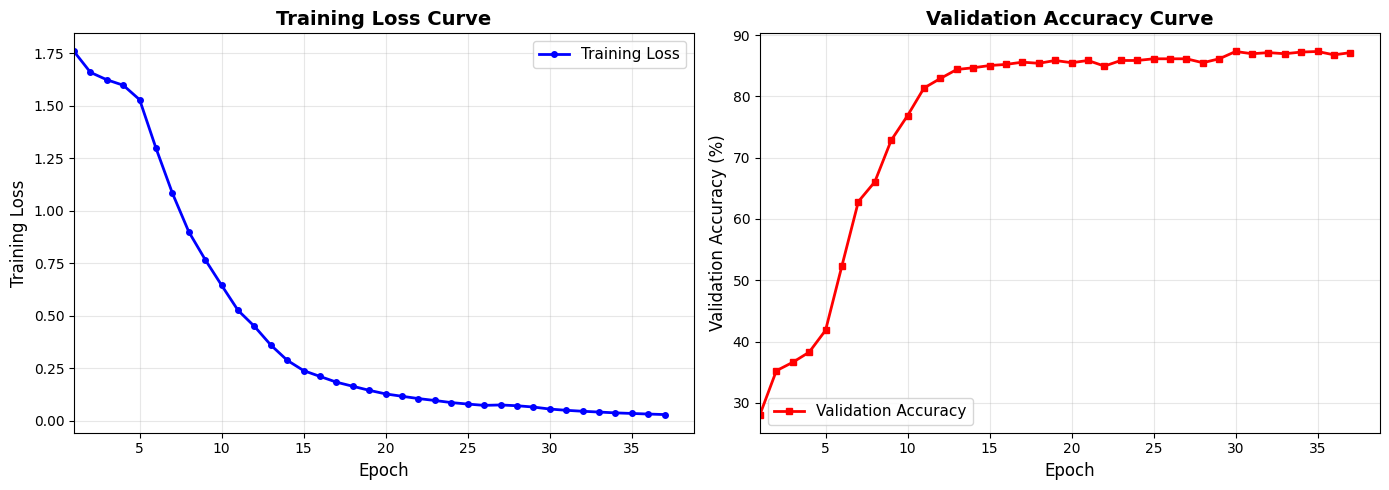


REGULARIZATION TUNING COMPLETE


In [25]:
# ============================================================================
# Regularization Final: All Best Combined
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION FINAL: ALL BEST SETTINGS COMBINED")
print("="*80)
print(f"Best settings from all steps:")
print(f"    Gradient Clipping: {best_grad_clip}")
print(f"    Dropout: {best_dropout}")
print(f"    L1 Lambda: {best_l1_lambda}")
print(f"    L2 Lambda: {best_l2_lambda}")

# Create model with all best settings
model = RNN_Classifier_Aggregation(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=best_hidden_dim,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=best_dropout,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    aggregation=best_aggregation['method']
).to(device)

# Select optimizer with best L2 (weight_decay)
if best_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
elif best_optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
elif best_optimizer == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
elif best_optimizer == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)

# Training loop
best_val_acc = 0.0
patience_counter = 0

# Store training history for plotting
train_losses = []
val_accs = []

print(f"\n>>> Training final model with all best regularization settings...")

for epoch in range(MAX_EPOCHS):
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []
    num_batches = 0
    
    for batch in train_iter:
        num_batches += 1
        text, text_lengths, labels = process_batch(batch, debug=False)
        optimizer.zero_grad()
        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, labels)
        
        if best_l1_lambda > 0:
            loss = loss + compute_l1_loss(model, best_l1_lambda)
        
        loss.backward()
        
        if best_grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
        
        optimizer.step()
        
        train_loss += loss.item()
        preds = torch.argmax(predictions, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    train_acc = accuracy_score(train_labels, train_preds)
    # Calculate average training loss (train_loss is sum over all batches)
    num_train_batches = len(train_labels) // train_iter.batch_size + (1 if len(train_labels) % train_iter.batch_size != 0 else 0)
    train_loss_avg = train_loss / num_train_batches if num_train_batches > 0 else train_loss
    
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in val_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(predictions, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Store training history for plotting
    train_losses.append(train_loss_avg)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_reg_final_best.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

# Evaluate on test set
model.load_state_dict(torch.load('rnn_reg_final_best.pt'))
model.eval()

test_loss = 0
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for batch in test_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        predictions = model(text, text_lengths)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_loss_avg = test_loss / len(test_iter)

try:
    test_probs_array = np.array(test_probs)
    test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

final_results = {
    'name': 'final_combined',
    'dropout': best_dropout,
    'grad_clip': best_grad_clip,
    'l1_lambda': best_l1_lambda,
    'l2_lambda': best_l2_lambda,
    'val_acc': best_val_acc,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_auc': test_auc
}

print(f"\n>>> Final Combined Results:")
print(f"    Configuration:")
print(f"      - Gradient Clipping: {best_grad_clip}")
print(f"      - Dropout: {best_dropout}")
print(f"      - L1 Lambda: {best_l1_lambda}")
print(f"      - L2 Lambda: {best_l2_lambda}")
print(f"    Validation Acc: {best_val_acc*100:.2f}%")
print(f"    Test Acc: {test_acc*100:.2f}%")
print(f"    Test F1: {test_f1:.4f}")
print(f"    Test AUC-ROC: {test_auc:.4f}")

# Compare with baseline
improvement = test_acc - baseline_results['test_acc']
improvement_pct = (improvement / baseline_results['test_acc']) * 100 if baseline_results['test_acc'] > 0 else 0

print(f"\n>>> Comparison with Baseline:")
print(f"    Baseline Test Acc: {baseline_results['test_acc']*100:.2f}%")
print(f"    Final Regularized Test Acc: {test_acc*100:.2f}%")
print(f"    Improvement: {improvement*100:+.2f}% ({improvement_pct:+.2f}% relative)")

# Plot training curves for best configuration and regularization
print(f"\n>>> Plotting training curves for best configuration and regularization...")
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss vs Epochs
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Curve', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=1)

# Plot 2: Validation Accuracy vs Epochs
ax2.plot(epochs, [acc*100 for acc in val_accs], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(left=1)

plt.tight_layout()
plt.savefig('best_config_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'best_config_training_curves.png'")
plt.show()

print(f"\n{'='*80}")
print("REGULARIZATION TUNING COMPLETE")
print(f"{'='*80}")


In [26]:
# ============================================================================
# Part 2(e): Topic-wise Accuracy Evaluation on Test Set
# ============================================================================
print("\n" + "="*80)
print("PART 2(e): TOPIC-WISE ACCURACY EVALUATION")
print("="*80)

# Load the best model from regularization tuning
# Use the model from the previous cell (regularization final) if available
# Otherwise, load it from the saved checkpoint

print("\n>>> Using model from regularization tuning...")

# Check if 'model' variable exists from the previous cell (cell 26)
try:
    # Try to use the model from the previous cell
    if 'model' in locals() or 'model' in globals():
        # Verify it's a valid model instance
        if hasattr(model, 'embedding') and hasattr(model, 'eval'):
            final_model = model
            final_model.eval()
            saved_vocab_size = final_model.embedding.weight.shape[0]
            print(f"    ✓ Using existing model from previous cell")
            print(f"    Model vocab size: {saved_vocab_size}")
        else:
            raise AttributeError("Model exists but is not valid")
    else:
        raise NameError("Model variable not found")
except (NameError, AttributeError):
    # Model doesn't exist or is invalid, load from checkpoint
    print("    Model not found in previous cell, loading from checkpoint...")
    try:
        checkpoint = torch.load('weights/rnn_reg_final_best.pt', map_location=device)
    except FileNotFoundError:
        checkpoint = torch.load('rnn_reg_final_best.pt', map_location=device)
    
    # Infer configuration from saved state dict
    saved_vocab_size = checkpoint['embedding.weight'].shape[0]
    saved_hidden_dim = checkpoint['rnn.weight_ih_l0'].shape[0]
    has_attention = 'attention.weight' in checkpoint
    saved_aggregation = 'attention' if has_attention else 'last'
    
    # Recreate model
    final_model = RNN_Classifier_Aggregation(
        vocab_size=saved_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=saved_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=None,
        aggregation=saved_aggregation
    ).to(device)
    
    final_model.load_state_dict(checkpoint, strict=True)
    final_model.eval()
    print(f"    ✓ Model loaded from checkpoint (vocab_size={saved_vocab_size})")

# Function to evaluate per topic
def evaluate_per_topic(model, iterator, device, max_vocab_size=None):
    """
    Evaluate model performance per topic category on the test set.
    Returns a dictionary with accuracy for each topic.
    
    Args:
        model: The trained model
        iterator: Data iterator for test set
        device: Device to run on
        max_vocab_size: Maximum valid vocabulary size (to clip token indices)
    """
    model.eval()
    
    # Dictionary to store correct and total counts per topic
    topic_correct = defaultdict(int)
    topic_total = defaultdict(int)
    
    # Get label vocabulary for mapping
    label_to_idx = LABEL.vocab.stoi
    idx_to_label = LABEL.vocab.itos
    
    # Get <unk> token index for mapping out-of-range tokens
    unk_idx = TEXT.vocab.stoi.get(TEXT.unk_token, 0)
    
    with torch.no_grad():
        for batch in iterator:
            # Process batch (should be on CPU from the iterator)
            text, text_lengths, labels = process_batch(batch, debug=False)
            
            # Clip token indices to valid range if max_vocab_size is specified
            # This handles cases where the current vocab is larger than the saved model's vocab
            if max_vocab_size is not None:
                # Map any indices >= max_vocab_size to <unk> token
                text = torch.where(text >= max_vocab_size, 
                                 torch.tensor(unk_idx, device=text.device, dtype=text.dtype), 
                                 text)
                # Also ensure no negative indices
                text = torch.clamp(text, min=0)
            
            # Move tensors to the actual device after clipping
            text = text.to(device)
            text_lengths = text_lengths.to(device)
            labels = labels.to(device)
            
            predictions = model(text, text_lengths)
            
            # Get predicted labels
            preds = torch.argmax(predictions, dim=1)
            
            # Convert to numpy for easier processing
            preds_np = preds.cpu().numpy()
            labels_np = labels.cpu().numpy()
            
            # Count correct and total for each topic
            for pred_idx, true_idx in zip(preds_np, labels_np):
                true_label = idx_to_label[true_idx]
                topic_total[true_label] += 1
                
                if pred_idx == true_idx:
                    topic_correct[true_label] += 1
    
    # Calculate accuracy per topic
    topic_accuracies = {}
    for label in sorted(topic_total.keys()):
        if topic_total[label] > 0:
            acc = topic_correct[label] / topic_total[label]
            topic_accuracies[label] = {
                'accuracy': acc,
                'correct': topic_correct[label],
                'total': topic_total[label]
            }
    
    return topic_accuracies

# Evaluate on test set
print("\n>>> Evaluating on test set...")

# Create a CPU iterator to avoid CUDA errors during numericalization with invalid token indices
# We'll process on CPU, clip indices, then move to device
from torchtext import data
cpu_device = torch.device('cpu')
test_iter_cpu = data.BucketIterator(
    test_data,
    batch_size=test_iter.batch_size,
    sort_key=lambda x: len(x.text),
    device=cpu_device,
    sort=False,
    shuffle=False
)

# Pass max_vocab_size to clip token indices to the saved model's vocabulary size
topic_accuracies = evaluate_per_topic(final_model, test_iter_cpu, device, max_vocab_size=saved_vocab_size)

# Display results
print("\n" + "="*80)
print("TOPIC-WISE ACCURACY ON TEST SET")
print("="*80)
print(f"{'Topic':<10} {'Accuracy':<12} {'Correct':<10} {'Total':<10} {'% of Test Set':<15}")
print("-" * 80)

# Calculate total test samples for percentage calculation
total_test_samples = sum(acc['total'] for acc in topic_accuracies.values())

for topic in sorted(topic_accuracies.keys()):
    acc_info = topic_accuracies[topic]
    acc_pct = acc_info['accuracy'] * 100
    correct = acc_info['correct']
    total = acc_info['total']
    pct_of_test = (total / total_test_samples) * 100 if total_test_samples > 0 else 0
    
    print(f"{topic:<10} {acc_pct:<12.2f} {correct:<10} {total:<10} {pct_of_test:<15.2f}")

# Calculate overall accuracy
overall_correct = sum(acc_info['correct'] for acc_info in topic_accuracies.values())
overall_total = sum(acc_info['total'] for acc_info in topic_accuracies.values())
overall_acc = overall_correct / overall_total if overall_total > 0 else 0

print("-" * 80)
print(f"{'OVERALL':<10} {overall_acc*100:<12.2f} {overall_correct:<10} {overall_total:<10} {'100.00':<15}")

# ============================================================================
# Discussion: What may cause differences in accuracies across topics
# ============================================================================
print("\n" + "="*80)
print("DISCUSSION: FACTORS AFFECTING TOPIC-WISE ACCURACY")
print("="*80)

# Get training distribution for comparison
train_label_counts = Counter([ex.label for ex in train_data.examples])
total_train = len(train_data.examples)

print("\n1. CLASS IMBALANCE IN TRAINING DATA:")
print(f"{'Topic':<10} {'Train Count':<15} {'Train %':<12} {'Test Count':<12} {'Test %':<12}")
print("-" * 70)
for topic in sorted(topic_accuracies.keys()):
    train_count = train_label_counts.get(topic, 0)
    train_pct = (train_count / total_train) * 100 if total_train > 0 else 0
    test_count = topic_accuracies[topic]['total']
    test_pct = (test_count / total_test_samples) * 100 if total_test_samples > 0 else 0
    print(f"{topic:<10} {train_count:<15} {train_pct:<12.2f} {test_count:<12} {test_pct:<12.2f}")

print("\n2. KEY OBSERVATIONS AND POTENTIAL CAUSES:")
print("\n   a) Class Imbalance Effect:")
print("      - Topics with fewer training examples (e.g., ABBR with only 1.58% of data)")
print("        may have lower accuracy due to insufficient learning signal")
print("      - The model may be biased toward more frequent classes during training")

print("\n   b) Semantic Complexity:")
print("      - Some topics may have more ambiguous or overlapping characteristics")
print("      - For example, ABBR (abbreviations) might be confused with other categories")
print("        if the context is not clear enough")

print("\n   c) Vocabulary and OOV Rates:")
print("      - Topics with higher OOV rates (as seen in Part 1) may have lower accuracy")
print("      - ABBR had 9.70% OOV rate (highest), which could contribute to lower performance")

print("\n   d) Question Type Characteristics:")
print("      - ENTY (entities) and HUM (humans) are more distinct and may be easier to classify")
print("      - DESC (descriptions) might overlap with other categories semantically")
print("      - NUM (numeric) questions may have distinctive patterns that aid classification")

print("\n   e) Model Capacity and Representation:")
print("      - The RNN may capture certain patterns better than others")
print("      - Aggregation method (attention/mean/max/last) may favor certain topic structures")

print("\n3. RECOMMENDATIONS FOR IMPROVEMENT:")
print("   - Use class weights in loss function to handle imbalance")
print("   - Apply data augmentation or oversampling for minority classes")
print("   - Consider focal loss to focus on hard examples")
print("   - Fine-tune embeddings specifically for underrepresented topics")
print("   - Use ensemble methods combining multiple models")

print("\n" + "="*80)
print("TOPIC-WISE EVALUATION COMPLETE")
print("="*80)



PART 2(e): TOPIC-WISE ACCURACY EVALUATION

>>> Using model from regularization tuning...
    ✓ Using existing model from previous cell
    Model vocab size: 8188

>>> Evaluating on test set...

TOPIC-WISE ACCURACY ON TEST SET
Topic      Accuracy     Correct    Total      % of Test Set  
--------------------------------------------------------------------------------
ABBR       77.78        7          9          1.80           
DESC       98.55        136        138        27.60          
ENTY       75.53        71         94         18.80          
HUM        89.23        58         65         13.00          
LOC        91.36        74         81         16.20          
NUM        85.84        97         113        22.60          
--------------------------------------------------------------------------------
OVERALL    88.60        443        500        100.00         

DISCUSSION: FACTORS AFFECTING TOPIC-WISE ACCURACY

1. CLASS IMBALANCE IN TRAINING DATA:
Topic      Train Count    

In [35]:
# ============================================================================
# Part 3.1: biLSTM and biGRU Models
# ============================================================================

print("\n" + "="*80)
print("PART 3.1: biLSTM AND biGRU MODELS")
print("="*80)

# biLSTM Model Class
class BiLSTMClassifier(nn.Module):
    """
    Bidirectional LSTM for topic classification.
    Uses pretrained embeddings (learnable/updated during training) with OOV mitigation.
    Incorporates recurrent computations in both directions and supports multiple layers.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.5, padding_idx=0, pretrained_embeddings=None):
        super(BiLSTMClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = True
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # Bidirectional LSTM layer with multiple layers
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        # For bidirectional LSTM, output dimension is hidden_dim * 2
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Get dimensions
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths
        text_lengths_flat = text_lengths.flatten().cpu().long()
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, "
                f"expected {batch_size}"
            )
        
        # Clamp lengths
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        
        # Pack the padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through bidirectional LSTM
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden: [n_layers * 2, batch_size, hidden_dim] (2 for bidirectional)
        # For bidirectional LSTM, we concatenate forward and backward hidden states
        # from the last layer
        forward_hidden = hidden[-2]  # [batch_size, hidden_dim]
        backward_hidden = hidden[-1]  # [batch_size, hidden_dim]
        last_hidden = torch.cat([forward_hidden, backward_hidden], dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        last_hidden = self.dropout(last_hidden)
        
        # Pass through fully connected layer
        output = self.fc(last_hidden)  # [batch_size, output_dim]
        
        return output


# biGRU Model Class
class BiGRUClassifier(nn.Module):
    """
    Bidirectional GRU for topic classification.
    Uses pretrained embeddings (learnable/updated during training) with OOV mitigation.
    Incorporates recurrent computations in both directions and supports multiple layers.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.5, padding_idx=0, pretrained_embeddings=None):
        super(BiGRUClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = True
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # Bidirectional GRU layer with multiple layers
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        # For bidirectional GRU, output dimension is hidden_dim * 2
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Get dimensions
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths
        text_lengths_flat = text_lengths.flatten().cpu().long()
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, "
                f"expected {batch_size}"
            )
        
        # Clamp lengths
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        
        # Pack the padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through bidirectional GRU
        packed_output, hidden = self.gru(packed_embedded)
        # hidden: [n_layers * 2, batch_size, hidden_dim] (2 for bidirectional)
        # For bidirectional GRU, we concatenate forward and backward hidden states
        # from the last layer
        forward_hidden = hidden[-2]  # [batch_size, hidden_dim]
        backward_hidden = hidden[-1]  # [batch_size, hidden_dim]
        last_hidden = torch.cat([forward_hidden, backward_hidden], dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        last_hidden = self.dropout(last_hidden)
        
        # Pass through fully connected layer
        output = self.fc(last_hidden)  # [batch_size, output_dim]
        
        return output

print(">>> Model classes created: BiLSTMClassifier and BiGRUClassifier")



PART 3.1: biLSTM AND biGRU MODELS
>>> Model classes created: BiLSTMClassifier and BiGRUClassifier


In [50]:
# Training function with history tracking for plotting curves
def train_model_with_history(model, train_iterator, val_iterator, optimizer, criterion, 
                             n_epochs, device, patience=10, model_name="model"):
    """
    Train the model with early stopping and track training history.
    Returns: model, training_history dictionary
    """
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_val_auc = 0.0
    patience_counter = 0
    best_model_state = None
    
    # History tracking
    train_losses = []
    val_losses = []
    val_accs = []
    val_f1s = []  # Add F1 tracking
    val_aucs = []  # Add AUROC tracking
    
    print(f"\n>>> Training {model_name}")
    print(f"    Parameters: {count_parameters(model):,}")
    print(f"    Max epochs: {n_epochs}, Patience: {patience}")
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iterator:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_iterator)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        val_probs = []  # Add probabilities for AUROC
        
        with torch.no_grad():
            for batch in val_iterator:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                probs = torch.softmax(predictions, dim=1)  # Get probabilities
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())  # Store probabilities
        
        avg_val_loss = val_loss / len(val_iterator)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')  # Calculate F1
        
        # Calculate AUC-ROC
        try:
            val_probs_array = np.array(val_probs)
            val_labels_bin = label_binarize(val_labels, classes=range(num_classes))
            val_auc = roc_auc_score(val_labels_bin, val_probs_array, average='weighted', multi_class='ovr')
        except Exception as e:
            print(f"Warning: Could not calculate AUC-ROC for {model_name} at epoch {epoch+1}: {e}")
            val_auc = 0.0
        
        # Store history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)  # Store F1
        val_aucs.append(val_auc)  # Store AUROC
        
        # Early stopping and model saving (using accuracy for early stopping)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_val_auc = val_auc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        print(f'Epoch: {epoch+1:02}/{n_epochs} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
        print(f'\tTrain Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}')
        
        if patience_counter >= patience:
            print(f'\t>>> Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%')
            break
    
    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f'\n>>> Training completed! Best validation accuracy: {best_val_acc*100:.2f}%')
    print(f'    Best validation F1: {best_val_f1:.4f}')
    print(f'    Best validation AUC-ROC: {best_val_auc:.4f}')
    
    # Return history dictionary
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'val_f1s': val_f1s,  # Add F1 history
        'val_aucs': val_aucs,  # Add AUROC history
        'best_val_acc': best_val_acc,
        'best_val_f1': best_val_f1,  # Add best F1
        'best_val_auc': best_val_auc,  # Add best AUROC
        'epochs_trained': len(train_losses)
    }
    
    return model, history

print(">>> Training function with history tracking created")


>>> Training function with history tracking created


In [51]:
# ============================================================================
# Train biLSTM Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING biLSTM MODEL")
print("="*80)

# Use best hyperparameters from Part 2 (or reasonable defaults)
# Based on Part 2 results, using: LR=0.0001, Batch=32, Hidden=512, but we'll use Hidden=256 for biLSTM
# since bidirectional doubles the effective hidden size
BILSTM_HIDDEN_DIM = 256  # Effective hidden size will be 512 (256*2) due to bidirectional
BILSTM_N_LAYERS = 2  # Stack multiple layers
BILSTM_DROPOUT = 0.5
BILSTM_BATCH_SIZE = 64
BILSTM_LEARNING_RATE = 0.001
BILSTM_N_EPOCHS = 100
BILSTM_PATIENCE = 10

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Create iterators
train_iter_bilstm = data.BucketIterator(
    train_data,
    batch_size=BILSTM_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_bilstm = data.BucketIterator(
    validation_data,
    batch_size=BILSTM_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_bilstm = data.BucketIterator(
    test_data,
    batch_size=BILSTM_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create biLSTM model
bilstm_model = BiLSTMClassifier(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=BILSTM_HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=BILSTM_N_LAYERS,
    dropout=BILSTM_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=BILSTM_LEARNING_RATE)

print(f"\n>>> biLSTM Model Configuration:")
print(f"    Hidden Dim: {BILSTM_HIDDEN_DIM} (effective: {BILSTM_HIDDEN_DIM * 2} due to bidirectional)")
print(f"    Layers: {BILSTM_N_LAYERS}")
print(f"    Dropout: {BILSTM_DROPOUT}")
print(f"    Learning Rate: {BILSTM_LEARNING_RATE}")
print(f"    Batch Size: {BILSTM_BATCH_SIZE}")
print(f"    Max Epochs: {BILSTM_N_EPOCHS}, Patience: {BILSTM_PATIENCE}")

# Train biLSTM
bilstm_model, bilstm_history = train_model_with_history(
    bilstm_model, train_iter_bilstm, val_iter_bilstm, bilstm_optimizer, criterion,
    BILSTM_N_EPOCHS, device, patience=BILSTM_PATIENCE, model_name="biLSTM"
)

# Save best model
torch.save(bilstm_model.state_dict(), 'weights/bilstm_best.pt')
print(f"\n>>> biLSTM model saved to 'weights/bilstm_best.pt'")



TRAINING biLSTM MODEL

>>> biLSTM Model Configuration:
    Hidden Dim: 256 (effective: 512 due to bidirectional)
    Layers: 2
    Dropout: 0.5
    Learning Rate: 0.001
    Batch Size: 64
    Max Epochs: 100, Patience: 10

>>> Training biLSTM
    Parameters: 5,179,222
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 1s
	Train Loss: 1.4050 | Train Acc: 38.81%
	Val Loss: 0.9629 | Val Acc: 68.26% | Val F1: 0.6825 | Val AUC: 0.9154
Epoch: 02/100 | Time: 0m 1s
	Train Loss: 0.6006 | Train Acc: 79.32%
	Val Loss: 0.5413 | Val Acc: 79.63% | Val F1: 0.7965 | Val AUC: 0.9611
Epoch: 03/100 | Time: 0m 1s
	Train Loss: 0.2500 | Train Acc: 92.30%
	Val Loss: 0.4824 | Val Acc: 83.49% | Val F1: 0.8337 | Val AUC: 0.9674
Epoch: 04/100 | Time: 0m 1s
	Train Loss: 0.0876 | Train Acc: 97.98%
	Val Loss: 0.5319 | Val Acc: 85.32% | Val F1: 0.8536 | Val AUC: 0.9723
Epoch: 05/100 | Time: 0m 1s
	Train Loss: 0.0306 | Train Acc: 99.29%
	Val Loss: 0.6669 | Val Acc: 85.69% | Val F1: 0.8586 | Val AUC: 0.9684
E

In [52]:
# ============================================================================
# Train biGRU Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING biGRU MODEL")
print("="*80)

# Use same hyperparameters as biLSTM for fair comparison
BIGRU_HIDDEN_DIM = 256  # Effective hidden size will be 512 (256*2) due to bidirectional
BIGRU_N_LAYERS = 2  # Stack multiple layers
BIGRU_DROPOUT = 0.5
BIGRU_BATCH_SIZE = 64
BIGRU_LEARNING_RATE = 0.001
BIGRU_N_EPOCHS = 100
BIGRU_PATIENCE = 10

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Create iterators
train_iter_bigru = data.BucketIterator(
    train_data,
    batch_size=BIGRU_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_bigru = data.BucketIterator(
    validation_data,
    batch_size=BIGRU_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_bigru = data.BucketIterator(
    test_data,
    batch_size=BIGRU_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create biGRU model
bigru_model = BiGRUClassifier(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=BIGRU_HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=BIGRU_N_LAYERS,
    dropout=BIGRU_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
bigru_optimizer = optim.Adam(bigru_model.parameters(), lr=BIGRU_LEARNING_RATE)

print(f"\n>>> biGRU Model Configuration:")
print(f"    Hidden Dim: {BIGRU_HIDDEN_DIM} (effective: {BIGRU_HIDDEN_DIM * 2} due to bidirectional)")
print(f"    Layers: {BIGRU_N_LAYERS}")
print(f"    Dropout: {BIGRU_DROPOUT}")
print(f"    Learning Rate: {BIGRU_LEARNING_RATE}")
print(f"    Batch Size: {BIGRU_BATCH_SIZE}")
print(f"    Max Epochs: {BIGRU_N_EPOCHS}, Patience: {BIGRU_PATIENCE}")

# Train biGRU
bigru_model, bigru_history = train_model_with_history(
    bigru_model, train_iter_bigru, val_iter_bigru, bigru_optimizer, criterion,
    BIGRU_N_EPOCHS, device, patience=BIGRU_PATIENCE, model_name="biGRU"
)

# Save best model
torch.save(bigru_model.state_dict(), 'weights/bigru_best.pt')
print(f"\n>>> biGRU model saved to 'weights/bigru_best.pt'")



TRAINING biGRU MODEL

>>> biGRU Model Configuration:
    Hidden Dim: 256 (effective: 512 due to bidirectional)
    Layers: 2
    Dropout: 0.5
    Learning Rate: 0.001
    Batch Size: 64
    Max Epochs: 100, Patience: 10

>>> Training biGRU
    Parameters: 4,499,286
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 1s
	Train Loss: 1.2177 | Train Acc: 50.78%
	Val Loss: 0.7018 | Val Acc: 75.96% | Val F1: 0.7618 | Val AUC: 0.9473
Epoch: 02/100 | Time: 0m 1s
	Train Loss: 0.4018 | Train Acc: 86.22%
	Val Loss: 0.4158 | Val Acc: 84.04% | Val F1: 0.8368 | Val AUC: 0.9764
Epoch: 03/100 | Time: 0m 1s
	Train Loss: 0.1068 | Train Acc: 96.61%
	Val Loss: 0.4774 | Val Acc: 84.95% | Val F1: 0.8489 | Val AUC: 0.9741
Epoch: 04/100 | Time: 0m 1s
	Train Loss: 0.0266 | Train Acc: 99.34%
	Val Loss: 0.5662 | Val Acc: 84.59% | Val F1: 0.8467 | Val AUC: 0.9752
Epoch: 05/100 | Time: 0m 1s
	Train Loss: 0.0075 | Train Acc: 99.75%
	Val Loss: 0.6763 | Val Acc: 84.13% | Val F1: 0.8391 | Val AUC: 0.9729
Epoc


PLOTTING TRAINING CURVES
    Saved training curves to 'part3_1_bilstm_bigru_training_curves.png'


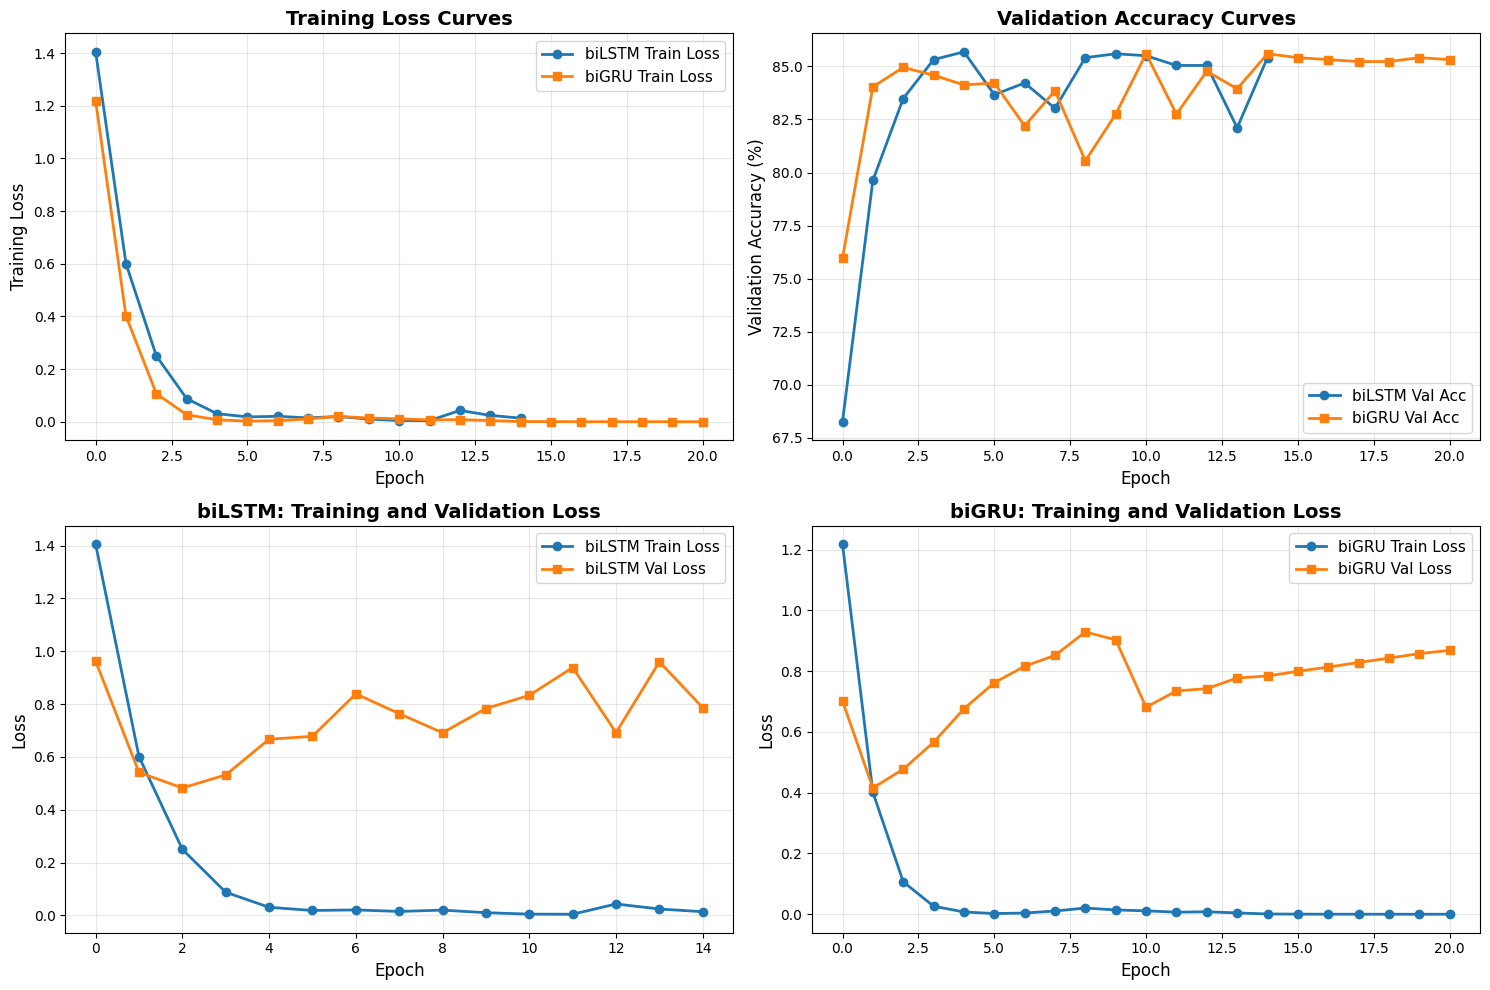

    Saved Part 3.1 curves to 'part3_1_training_curves.png'


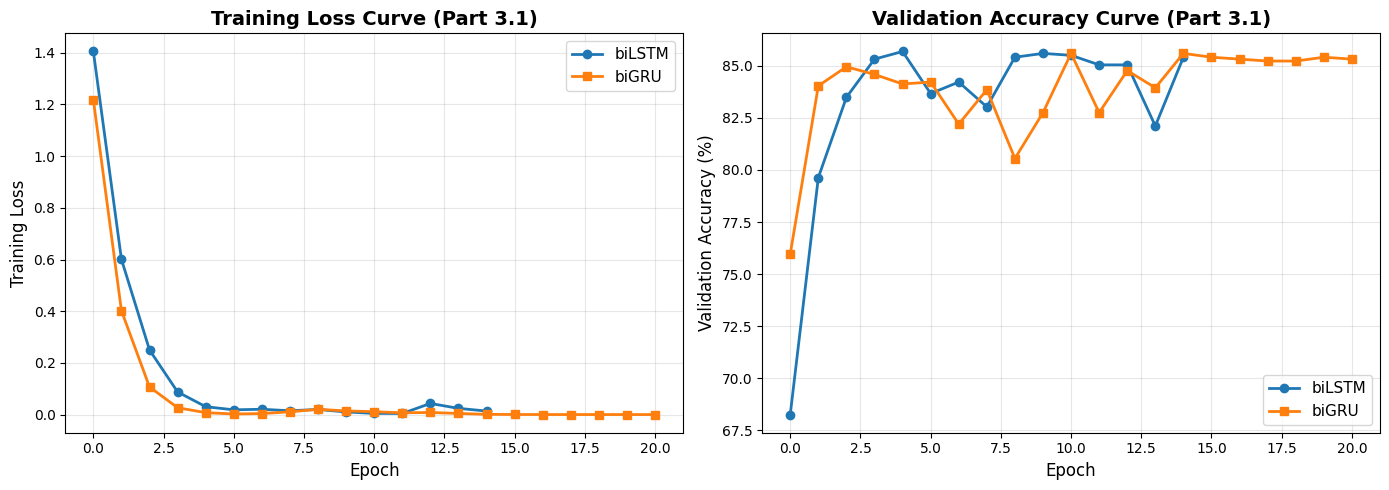

In [53]:
# ============================================================================
# Plot Training Curves for biLSTM and biGRU
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES")
print("="*80)

import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss Curves
axes[0, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Curves', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Curves
axes[0, 1].plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM Val Acc', marker='o', linewidth=2)
axes[0, 1].plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU Val Acc', marker='s', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Validation Accuracy Curves', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: biLSTM Training and Validation Loss
axes[1, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
axes[1, 0].plot(bilstm_history['val_losses'], label='biLSTM Val Loss', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('biLSTM: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: biGRU Training and Validation Loss
axes[1, 1].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='o', linewidth=2)
axes[1, 1].plot(bigru_history['val_losses'], label='biGRU Val Loss', marker='s', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Loss', fontsize=12)
axes[1, 1].set_title('biGRU: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_1_bilstm_bigru_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_1_bilstm_bigru_training_curves.png'")
plt.show()

# Also create separate plots for Part 3.1 requirement (training loss and validation accuracy)
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss Curve
ax1.plot(bilstm_history['train_losses'], label='biLSTM', marker='o', linewidth=2)
ax1.plot(bigru_history['train_losses'], label='biGRU', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Curve (Part 3.1)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM', marker='o', linewidth=2)
ax2.plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (Part 3.1)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_1_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.1 curves to 'part3_1_training_curves.png'")
plt.show()


In [54]:
# ============================================================================
# Evaluate biLSTM and biGRU on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - biLSTM AND biGRU")
print("="*80)

def evaluate_model(model, iterator, criterion, device, model_name):
    """Evaluate model on test set and return metrics"""
    model.eval()
    test_loss = 0
    test_preds = []
    test_labels = []
    test_probs = []
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            probs = torch.softmax(predictions, dim=1)
            preds = torch.argmax(predictions, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
    
    avg_test_loss = test_loss / len(iterator)
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    
    # Calculate AUC-ROC
    try:
        test_probs_array = np.array(test_probs)
        test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
        test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
    except Exception as e:
        print(f"Warning: Could not calculate AUC-ROC for {model_name}: {e}")
        test_auc = 0.0
    
    return avg_test_loss, test_acc, test_f1, test_auc

# Evaluate biLSTM
print("\n>>> Evaluating biLSTM on test set...")
bilstm_test_loss, bilstm_test_acc, bilstm_test_f1, bilstm_test_auc = evaluate_model(
    bilstm_model, test_iter_bilstm, criterion, device, "biLSTM"
)

print(f"\n>>> biLSTM Test Set Results:")
print(f"    Test Loss: {bilstm_test_loss:.4f}")
print(f"    Test Accuracy: {bilstm_test_acc*100:.2f}%")
print(f"    Test F1 Score: {bilstm_test_f1:.4f}")
print(f"    Test AUC-ROC: {bilstm_test_auc:.4f}")

# Evaluate biGRU
print("\n>>> Evaluating biGRU on test set...")
bigru_test_loss, bigru_test_acc, bigru_test_f1, bigru_test_auc = evaluate_model(
    bigru_model, test_iter_bigru, criterion, device, "biGRU"
)

print(f"\n>>> biGRU Test Set Results:")
print(f"    Test Loss: {bigru_test_loss:.4f}")
print(f"    Test Accuracy: {bigru_test_acc*100:.2f}%")
print(f"    Test F1 Score: {bigru_test_f1:.4f}")
print(f"    Test AUC-ROC: {bigru_test_auc:.4f}")

# Summary comparison
print("\n" + "="*80)
print("PART 3.1 SUMMARY - biLSTM vs biGRU")
print("="*80)
print(f"{'Model':<10} {'Test Accuracy':<15} {'Test F1':<12} {'Val Acc (Best)':<15}")
print("-" * 60)
print(f"{'biLSTM':<10} {bilstm_test_acc*100:<15.2f}% {bilstm_test_f1:<12.4f} {bilstm_history['best_val_acc']*100:<15.2f}%")
print(f"{'biGRU':<10} {bigru_test_acc*100:<15.2f}% {bigru_test_f1:<12.4f} {bigru_history['best_val_acc']*100:<15.2f}%")
print("="*80)

print("\n>>> Part 3.1 Complete!")
print("    - biLSTM and biGRU models trained with bidirectional and multiple layers")
print("    - Training curves plotted and saved")
print("    - Test set accuracies reported above")



TEST SET EVALUATION - biLSTM AND biGRU

>>> Evaluating biLSTM on test set...

>>> biLSTM Test Set Results:
    Test Loss: 0.8182
    Test Accuracy: 84.40%
    Test F1 Score: 0.8403
    Test AUC-ROC: 0.9558

>>> Evaluating biGRU on test set...

>>> biGRU Test Set Results:
    Test Loss: 0.8475
    Test Accuracy: 86.20%
    Test F1 Score: 0.8590
    Test AUC-ROC: 0.9701

PART 3.1 SUMMARY - biLSTM vs biGRU
Model      Val Acc      Val F1       Val AUC      Test Acc     Test F1      Test AUC    
--------------------------------------------------------------------------------
biLSTM     85.69       % 0.8586       0.9684       84.40       % 0.8403       0.9558      
biGRU      85.60       % 0.8566       0.9727       86.20       % 0.8590       0.9701      

>>> Part 3.1 Complete!
    - biLSTM and biGRU models trained with bidirectional and multiple layers
    - Training curves plotted and saved
    - Validation and test set metrics (Accuracy, F1, AUC-ROC) reported above


In [65]:
# ============================================================================
# Part 3.2: Convolutional Neural Network (CNN) Model
# ============================================================================
# Replace simple RNN with CNN to produce sentence representations and perform topic classification

print("\n" + "="*80)
print("PART 3.2: CONVOLUTIONAL NEURAL NETWORK (CNN) MODEL")
print("="*80)

class CNNClassifier(nn.Module):
    """
    CNN for text classification using multiple filter sizes (n-gram features)
    Uses convolutional layers to extract local features and max pooling to create sentence representation
    """
    def __init__(self, vocab_size, embedding_dim, output_dim, 
                 num_filters=100, filter_sizes=[3, 4, 5], dropout=0.5, 
                 padding_idx=0, pretrained_embeddings=None):
        super(CNNClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # Convolutional layers with different filter sizes
        # Each filter size captures different n-gram patterns (e.g., 3-grams, 4-grams, 5-grams)
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=filter_size,
                padding=filter_size // 2  # Padding to maintain sequence length
            )
            for filter_size in filter_sizes
        ])
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        # Input size is num_filters * len(filter_sizes) (concatenated features from all filters)
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size] (not used in CNN, but kept for interface compatibility)
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # CNN expects input as [batch_size, channels, seq_len]
        # So we need to transpose: [batch_size, embedding_dim, seq_len]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        # Apply each convolutional filter and max pooling
        conv_outputs = []
        for conv in self.convs:
            # Convolution: [batch_size, num_filters, seq_len]
            conv_out = conv(embedded)
            # Apply ReLU activation
            conv_out = torch.relu(conv_out)
            
            # Max pooling over time dimension (seq_len)
            # This extracts the most important feature for each filter
            pooled = torch.max(conv_out, dim=2)[0]  # [batch_size, num_filters]
            conv_outputs.append(pooled)
        
        # Concatenate features from all filter sizes
        # This combines information from different n-gram patterns
        concatenated = torch.cat(conv_outputs, dim=1)  # [batch_size, num_filters * len(filter_sizes)]
        
        # Apply dropout
        concatenated = self.dropout(concatenated)
        
        # Pass through fully connected layer
        output = self.fc(concatenated)  # [batch_size, output_dim]
        
        return output

print(">>> CNNClassifier model class created")
print("    - Uses multiple convolutional filters with different sizes (3, 4, 5)")
print("    - Captures n-gram features at different scales")
print("    - Max pooling to create sentence representation")
print("    - Concatenates features from all filter sizes")




PART 3.2: CONVOLUTIONAL NEURAL NETWORK (CNN) MODEL
>>> CNNClassifier model class created
    - Uses multiple convolutional filters with different sizes (3, 4, 5)
    - Captures n-gram features at different scales
    - Max pooling to create sentence representation
    - Concatenates features from all filter sizes


In [66]:
# ============================================================================
# Train CNN Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING CNN MODEL")
print("="*80)

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters for CNN
CNN_NUM_FILTERS = 100  # Number of filters per filter size
CNN_FILTER_SIZES = [3, 4, 5]  # Different n-gram sizes to capture
CNN_DROPOUT = 0.5
CNN_BATCH_SIZE = 64
CNN_LEARNING_RATE = 0.001
CNN_N_EPOCHS = 100
CNN_PATIENCE = 10

# Create data iterators
train_iter_cnn = data.BucketIterator(
    train_data,
    batch_size=CNN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_cnn = data.BucketIterator(
    validation_data,
    batch_size=CNN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_cnn = data.BucketIterator(
    test_data,
    batch_size=CNN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create CNN model
cnn_model = CNNClassifier(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    output_dim=num_classes,
    num_filters=CNN_NUM_FILTERS,
    filter_sizes=CNN_FILTER_SIZES,
    dropout=CNN_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=CNN_LEARNING_RATE)

print(f"\n>>> CNN Model Configuration:")
print(f"    Number of Filters: {CNN_NUM_FILTERS} per filter size")
print(f"    Filter Sizes: {CNN_FILTER_SIZES} (captures {', '.join([f'{s}-grams' for s in CNN_FILTER_SIZES])})")
print(f"    Total Feature Size: {CNN_NUM_FILTERS * len(CNN_FILTER_SIZES)}")
print(f"    Dropout: {CNN_DROPOUT}")
print(f"    Learning Rate: {CNN_LEARNING_RATE}")
print(f"    Batch Size: {CNN_BATCH_SIZE}")
print(f"    Max Epochs: {CNN_N_EPOCHS}, Patience: {CNN_PATIENCE}")

# Train CNN model
cnn_model, cnn_history = train_model_with_history(
    cnn_model, train_iter_cnn, val_iter_cnn, cnn_optimizer, criterion,
    CNN_N_EPOCHS, device, patience=CNN_PATIENCE, model_name="CNN"
)

# Save best model
torch.save(cnn_model.state_dict(), 'weights/cnn_best.pt')
print(f"\n>>> CNN model saved to 'weights/cnn_best.pt'")




TRAINING CNN MODEL

>>> CNN Model Configuration:
    Number of Filters: 100 per filter size
    Filter Sizes: [3, 4, 5] (captures 3-grams, 4-grams, 5-grams)
    Total Feature Size: 300
    Dropout: 0.5
    Learning Rate: 0.001
    Batch Size: 64
    Max Epochs: 100, Patience: 10

>>> Training CNN
    Parameters: 2,818,506
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 0s
	Train Loss: 1.4234 | Train Acc: 43.83%
	Val Loss: 0.8830 | Val Acc: 75.32% | Val F1: 0.7543 | Val AUC: 0.9347
Epoch: 02/100 | Time: 0m 0s
	Train Loss: 0.6531 | Train Acc: 78.52%
	Val Loss: 0.4598 | Val Acc: 85.69% | Val F1: 0.8527 | Val AUC: 0.9767
Epoch: 03/100 | Time: 0m 0s
	Train Loss: 0.2582 | Train Acc: 92.94%
	Val Loss: 0.3349 | Val Acc: 88.99% | Val F1: 0.8894 | Val AUC: 0.9841
Epoch: 04/100 | Time: 0m 0s
	Train Loss: 0.0974 | Train Acc: 97.98%
	Val Loss: 0.3197 | Val Acc: 89.08% | Val F1: 0.8911 | Val AUC: 0.9851
Epoch: 05/100 | Time: 0m 0s
	Train Loss: 0.0402 | Train Acc: 99.17%
	Val Loss: 0.3185

In [67]:
# ============================================================================
# Evaluate CNN Model on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - CNN")
print("="*80)

# Evaluate CNN
print("\n>>> Evaluating CNN on test set...")
cnn_test_loss, cnn_test_acc, cnn_test_f1, cnn_test_auc = evaluate_model(
    cnn_model, test_iter_cnn, criterion, device, "CNN"
)

print(f"\n>>> CNN Test Set Results:")
print(f"    Test Loss: {cnn_test_loss:.4f}")
print(f"    Test Accuracy: {cnn_test_acc*100:.2f}%")
print(f"    Test F1 Score: {cnn_test_f1:.4f}")
print(f"    Test AUC-ROC: {cnn_test_auc:.4f}")




TEST SET EVALUATION - CNN

>>> Evaluating CNN on test set...

>>> CNN Test Set Results:
    Test Loss: 0.3575
    Test Accuracy: 90.60%
    Test F1 Score: 0.9047
    Test AUC-ROC: 0.9866


In [71]:
# ============================================================================
# Part 3.2 Summary - CNN Model
# ============================================================================

print("\n" + "="*80)
print("PART 3.2 SUMMARY - CNN MODEL")
print("="*80)
print(f"{'Model':<15} {'Val Acc':<12} {'Val F1':<12} {'Val AUC':<12} {'Test Acc':<12} {'Test F1':<12} {'Test AUC':<12}")
print("-" * 90)
print(f"{'CNN':<15} {cnn_history['best_val_acc']*100:<12.2f}% {cnn_history['best_val_f1']:<12.4f} {cnn_history['best_val_auc']:<12.4f} {cnn_test_acc*100:<12.2f}% {cnn_test_f1:<12.4f} {cnn_test_auc:<12.4f}")
print("="*90)

print("\n>>> Part 3.2 Complete!")
print("    - CNN model implemented with multiple filter sizes (3, 4, 5)")
print("    - Captures n-gram features at different scales")
print("    - Max pooling to create sentence representation")
print("    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets")




PART 3.2 SUMMARY - CNN MODEL
Model           Val Acc      Val F1       Val AUC      Test Acc     Test F1      Test AUC    
------------------------------------------------------------------------------------------
CNN             89.08       % 0.8911       0.9851       90.60       % 0.9047       0.9866      

>>> Part 3.2 Complete!
    - CNN model implemented with multiple filter sizes (3, 4, 5)
    - Captures n-gram features at different scales
    - Max pooling to create sentence representation
    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets



PLOTTING TRAINING CURVES - CNN
    Saved training curves to 'part3_2_cnn_training_curves.png'


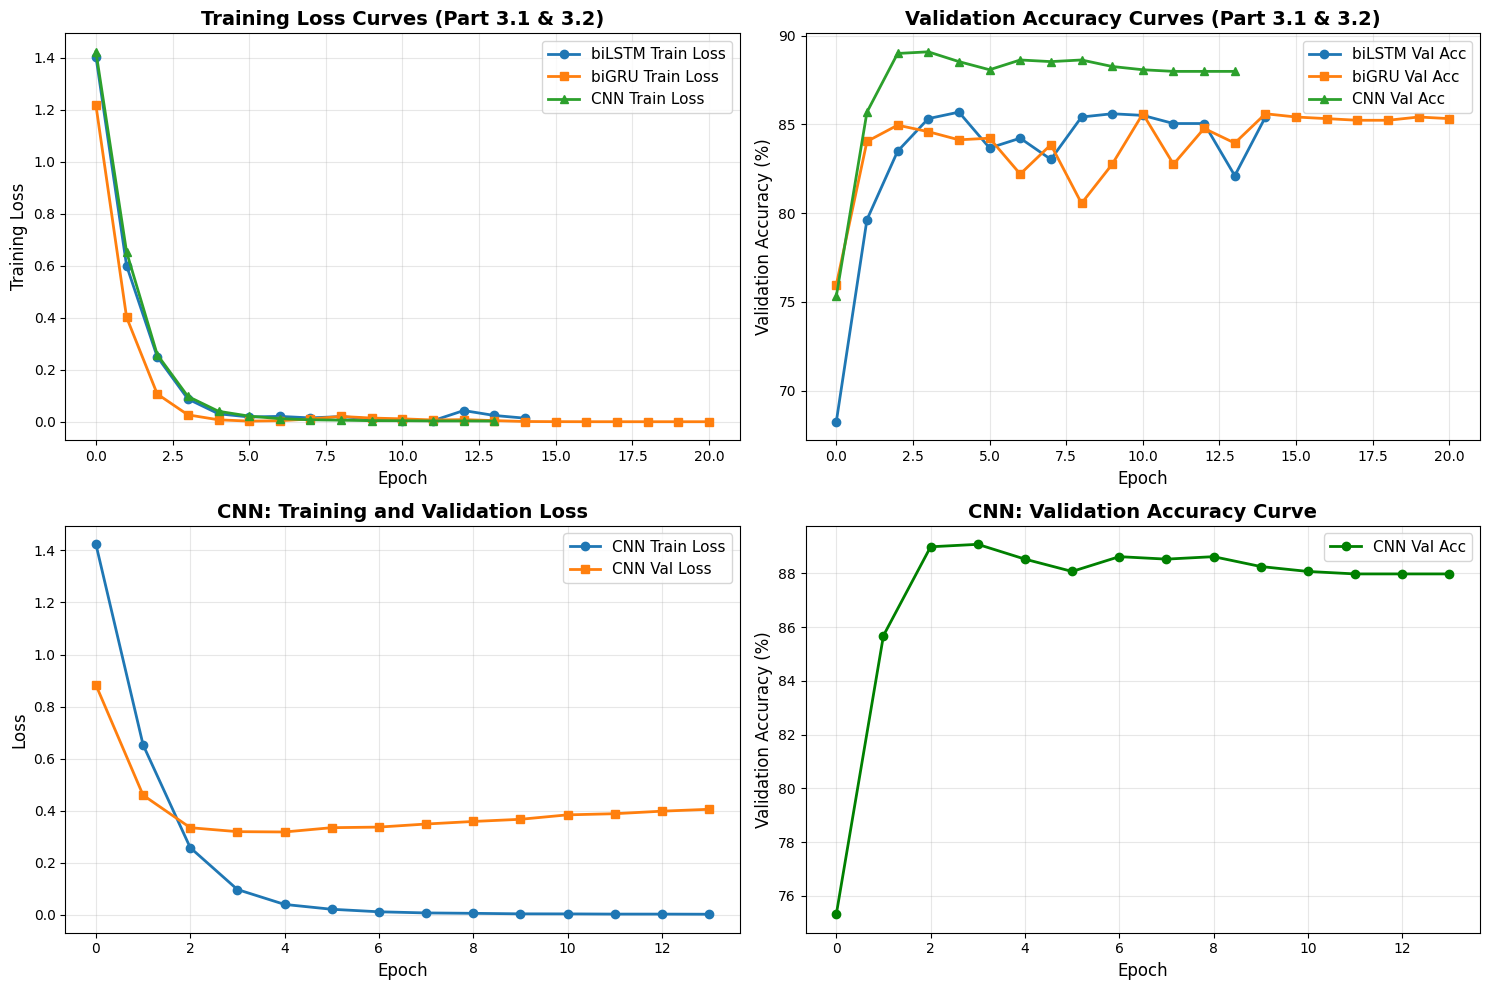

    Saved Part 3.2 curves to 'part3_2_training_curves.png'


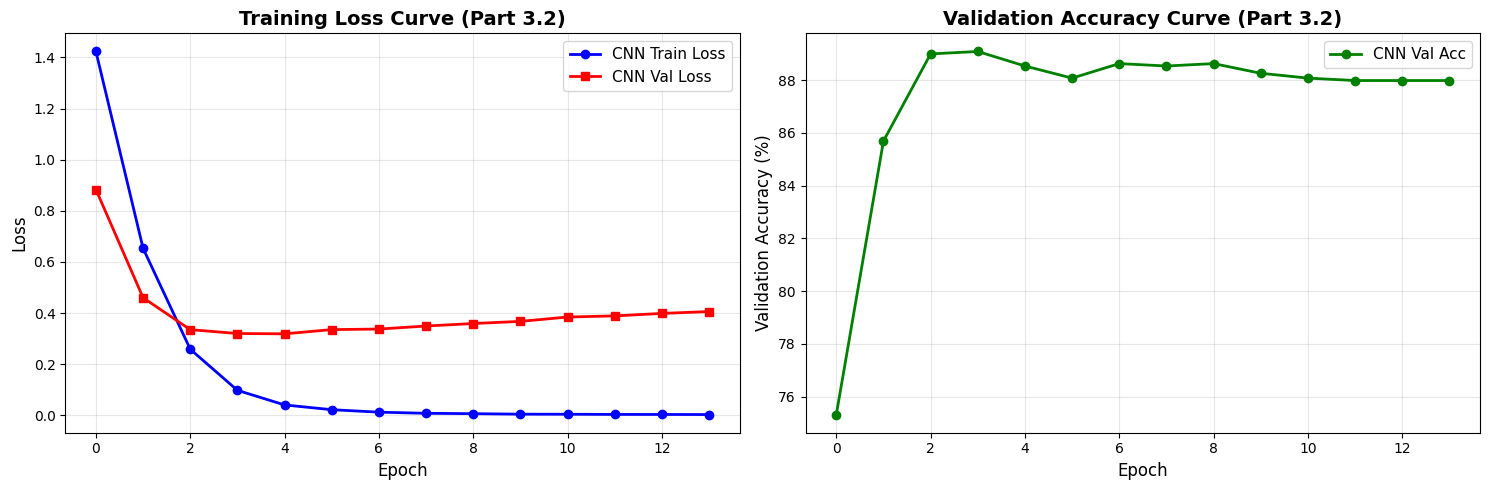


>>> Training curves plotted and saved for CNN model


In [72]:
# ============================================================================
# Plot Training Curves for CNN
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES - CNN")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss Curves (Comparison: biLSTM, biGRU, CNN)
axes[0, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='s', linewidth=2)
axes[0, 0].plot(cnn_history['train_losses'], label='CNN Train Loss', marker='^', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Curves (Part 3.1 & 3.2)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Curves (Comparison: biLSTM, biGRU, CNN)
axes[0, 1].plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM Val Acc', marker='o', linewidth=2)
axes[0, 1].plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU Val Acc', marker='s', linewidth=2)
axes[0, 1].plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='^', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Validation Accuracy Curves (Part 3.1 & 3.2)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: CNN Training and Validation Loss
axes[1, 0].plot(cnn_history['train_losses'], label='CNN Train Loss', marker='o', linewidth=2)
axes[1, 0].plot(cnn_history['val_losses'], label='CNN Val Loss', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('CNN: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: CNN Training and Validation Accuracy
axes[1, 1].plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='o', linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[1, 1].set_title('CNN: Validation Accuracy Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_2_cnn_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_2_cnn_training_curves.png'")
plt.show()  # Display the plot in notebook

# Also create separate plots for Part 3.2 requirement (training loss and validation accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(cnn_history['train_losses'], label='CNN Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(cnn_history['val_losses'], label='CNN Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (Part 3.2)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='o', linewidth=2, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (Part 3.2)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_2_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.2 curves to 'part3_2_training_curves.png'")
plt.show()  # Display the plot in notebook

print("\n>>> Training curves plotted and saved for CNN model")



In [70]:
# ============================================================================
# Part 3.1 & 3.2 Comparison: BiLSTM vs BiGRU vs CNN
# ============================================================================

print("\n" + "="*80)
print("COMPARISON: biLSTM vs biGRU vs CNN")
print("="*80)
print(f"{'Model':<15} {'Val Acc':<12} {'Val F1':<12} {'Val AUC':<12} {'Test Acc':<12} {'Test F1':<12} {'Test AUC':<12}")
print("-" * 90)
print(f"{'biLSTM':<15} {bilstm_history['best_val_acc']*100:<12.2f}% {bilstm_history['best_val_f1']:<12.4f} {bilstm_history['best_val_auc']:<12.4f} {bilstm_test_acc*100:<12.2f}% {bilstm_test_f1:<12.4f} {bilstm_test_auc:<12.4f}")
print(f"{'biGRU':<15} {bigru_history['best_val_acc']*100:<12.2f}% {bigru_history['best_val_f1']:<12.4f} {bigru_history['best_val_auc']:<12.4f} {bigru_test_acc*100:<12.2f}% {bigru_test_f1:<12.4f} {bigru_test_auc:<12.4f}")
print(f"{'CNN':<15} {cnn_history['best_val_acc']*100:<12.2f}% {cnn_history['best_val_f1']:<12.4f} {cnn_history['best_val_auc']:<12.4f} {cnn_test_acc*100:<12.2f}% {cnn_test_f1:<12.4f} {cnn_test_auc:<12.4f}")
print("="*90)

# Find best model based on test accuracy
models_comparison = {
    'biLSTM': {
        'val_acc': bilstm_history['best_val_acc'],
        'val_f1': bilstm_history['best_val_f1'],
        'val_auc': bilstm_history['best_val_auc'],
        'test_acc': bilstm_test_acc,
        'test_f1': bilstm_test_f1,
        'test_auc': bilstm_test_auc
    },
    'biGRU': {
        'val_acc': bigru_history['best_val_acc'],
        'val_f1': bigru_history['best_val_f1'],
        'val_auc': bigru_history['best_val_auc'],
        'test_acc': bigru_test_acc,
        'test_f1': bigru_test_f1,
        'test_auc': bigru_test_auc
    },
    'CNN': {
        'val_acc': cnn_history['best_val_acc'],
        'val_f1': cnn_history['best_val_f1'],
        'val_auc': cnn_history['best_val_auc'],
        'test_acc': cnn_test_acc,
        'test_f1': cnn_test_f1,
        'test_auc': cnn_test_auc
    }
}

best_model_test_acc = max(models_comparison.items(), key=lambda x: x[1]['test_acc'])
best_model_val_acc = max(models_comparison.items(), key=lambda x: x[1]['val_acc'])

print(f"\n>>> Best Model by Test Accuracy: {best_model_test_acc[0]}")
print(f"    Test Accuracy: {best_model_test_acc[1]['test_acc']*100:.2f}%")
print(f"    Test F1: {best_model_test_acc[1]['test_f1']:.4f}")
print(f"    Test AUC-ROC: {best_model_test_acc[1]['test_auc']:.4f}")

print(f"\n>>> Best Model by Validation Accuracy: {best_model_val_acc[0]}")
print(f"    Validation Accuracy: {best_model_val_acc[1]['val_acc']*100:.2f}%")
print(f"    Validation F1: {best_model_val_acc[1]['val_f1']:.4f}")
print(f"    Validation AUC-ROC: {best_model_val_acc[1]['val_auc']:.4f}")

print("\n>>> Model Architecture Comparison:")
print("    - biLSTM: Bidirectional LSTM with 2 layers, captures sequential dependencies in both directions")
print("    - biGRU: Bidirectional GRU with 2 layers, similar to biLSTM but with fewer parameters")
print("    - CNN: Convolutional layers with multiple filter sizes (3, 4, 5), captures n-gram patterns")




COMPARISON: biLSTM vs biGRU vs CNN
Model           Val Acc      Val F1       Val AUC      Test Acc     Test F1      Test AUC    
------------------------------------------------------------------------------------------
biLSTM          85.69       % 0.8586       0.9684       84.40       % 0.8403       0.9558      
biGRU           85.60       % 0.8566       0.9727       86.20       % 0.8590       0.9701      
CNN             89.08       % 0.8911       0.9851       90.60       % 0.9047       0.9866      

>>> Best Model by Test Accuracy: CNN
    Test Accuracy: 90.60%
    Test F1: 0.9047
    Test AUC-ROC: 0.9866

>>> Best Model by Validation Accuracy: CNN
    Validation Accuracy: 89.08%
    Validation F1: 0.8911
    Validation AUC-ROC: 0.9851

>>> Model Architecture Comparison:
    - biLSTM: Bidirectional LSTM with 2 layers, captures sequential dependencies in both directions
    - biGRU: Bidirectional GRU with 2 layers, similar to biLSTM but with fewer parameters
    - CNN: Convolutiona

In [ ]:
# # c) 

# 1: (hybrid model) rnn + attention layer
# 2: (hybrid model) cnn + bilstm + attention layer
# 3: (hybrid model) bigru + pretrained transformer (berto)

In [55]:
# ============================================================================
# Part 3.3: RNN + Attention Layer Model
# ============================================================================
# This implements a more sophisticated attention mechanism (additive/Bahdanau-style)
# compared to the simple linear attention used in Part 2

print("\n" + "="*80)
print("PART 3.3: RNN + ATTENTION LAYER MODEL")
print("="*80)

class RNNWithAttentionClassifier(nn.Module):
    """
    RNN with Additive Attention Mechanism (Bahdanau-style)
    This is a more sophisticated attention mechanism than simple linear attention.
    Uses a feed-forward network to compute attention scores.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.5, padding_idx=0, pretrained_embeddings=None,
                 attention_dim=None):
        super(RNNWithAttentionClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.attention_dim = attention_dim if attention_dim else hidden_dim
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # Bidirectional LSTM layer (using LSTM for better performance)
        self.rnn = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,  # Bidirectional for better context
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Additive Attention Mechanism (Bahdanau-style)
        # Attention uses a feed-forward network instead of simple linear layer
        # This is more expressive and can learn complex attention patterns
        self.attention_linear1 = nn.Linear(hidden_dim * 2, self.attention_dim)  # *2 for bidirectional
        self.attention_linear2 = nn.Linear(self.attention_dim, 1)
        self.tanh = nn.Tanh()
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        # Input is hidden_dim * 2 (bidirectional) after attention
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Pack sequences for efficient RNN processing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # Pass through bidirectional LSTM
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # hidden: [n_layers * 2, batch_size, hidden_dim] (2 for bidirectional)
        
        # Unpack the sequences
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # output: [batch_size, seq_len, hidden_dim * 2]
        
        # Apply Additive Attention Mechanism
        # Step 1: Compute attention scores using feed-forward network
        # This is more sophisticated than simple linear attention
        attention_scores = self.attention_linear1(output)  # [batch_size, seq_len, attention_dim]
        attention_scores = self.tanh(attention_scores)  # Apply tanh activation
        attention_scores = self.attention_linear2(attention_scores).squeeze(2)  # [batch_size, seq_len]
        
        # Step 2: Mask padding positions
        batch_size, seq_len = output.size(0), output.size(1)
        mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths.unsqueeze(1)
        attention_scores = attention_scores.masked_fill(~mask, float('-inf'))
        
        # Step 3: Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, seq_len, 1]
        
        # Step 4: Compute weighted sum of RNN outputs
        # This gives us a context vector that focuses on important parts of the sequence
        context_vector = torch.sum(attention_weights * output, dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Pass through fully connected layer
        output = self.fc(context_vector)  # [batch_size, output_dim]
        
        return output

print(">>> RNNWithAttentionClassifier model class created")
print("    - Uses bidirectional LSTM for encoding")
print("    - Implements additive attention mechanism (Bahdanau-style)")
print("    - More sophisticated than simple linear attention")




PART 3.3: RNN + ATTENTION LAYER MODEL
>>> RNNWithAttentionClassifier model class created
    - Uses bidirectional LSTM for encoding
    - Implements additive attention mechanism (Bahdanau-style)
    - More sophisticated than simple linear attention


In [56]:
# ============================================================================
# Train RNN + Attention Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING RNN + ATTENTION MODEL")
print("="*80)

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters (using similar settings to BiLSTM/BiGRU for fair comparison)
RNN_ATTN_HIDDEN_DIM = 256  # Effective hidden size will be 512 (256*2) due to bidirectional
RNN_ATTN_N_LAYERS = 2
RNN_ATTN_DROPOUT = 0.5
RNN_ATTN_BATCH_SIZE = 64
RNN_ATTN_LEARNING_RATE = 0.001
RNN_ATTN_N_EPOCHS = 100
RNN_ATTN_PATIENCE = 10
RNN_ATTN_ATTENTION_DIM = 256  # Dimension for attention mechanism

# Create data iterators
train_iter_rnn_attn = data.BucketIterator(
    train_data,
    batch_size=RNN_ATTN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_rnn_attn = data.BucketIterator(
    validation_data,
    batch_size=RNN_ATTN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_rnn_attn = data.BucketIterator(
    test_data,
    batch_size=RNN_ATTN_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create RNN + Attention model
rnn_attn_model = RNNWithAttentionClassifier(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=RNN_ATTN_HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=RNN_ATTN_N_LAYERS,
    dropout=RNN_ATTN_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    attention_dim=RNN_ATTN_ATTENTION_DIM
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
rnn_attn_optimizer = optim.Adam(rnn_attn_model.parameters(), lr=RNN_ATTN_LEARNING_RATE)

print(f"\n>>> RNN + Attention Model Configuration:")
print(f"    Hidden Dim: {RNN_ATTN_HIDDEN_DIM} (effective: {RNN_ATTN_HIDDEN_DIM * 2} due to bidirectional)")
print(f"    Layers: {RNN_ATTN_N_LAYERS}")
print(f"    Dropout: {RNN_ATTN_DROPOUT}")
print(f"    Attention Dim: {RNN_ATTN_ATTENTION_DIM}")
print(f"    Learning Rate: {RNN_ATTN_LEARNING_RATE}")
print(f"    Batch Size: {RNN_ATTN_BATCH_SIZE}")
print(f"    Max Epochs: {RNN_ATTN_N_EPOCHS}, Patience: {RNN_ATTN_PATIENCE}")

# Train RNN + Attention model
rnn_attn_model, rnn_attn_history = train_model_with_history(
    rnn_attn_model, train_iter_rnn_attn, val_iter_rnn_attn, rnn_attn_optimizer, criterion,
    RNN_ATTN_N_EPOCHS, device, patience=RNN_ATTN_PATIENCE, model_name="RNN+Attention"
)

# Save best model
torch.save(rnn_attn_model.state_dict(), 'weights/rnn_attention_best.pt')
print(f"\n>>> RNN + Attention model saved to 'weights/rnn_attention_best.pt'")




TRAINING RNN + ATTENTION MODEL

>>> RNN + Attention Model Configuration:
    Hidden Dim: 256 (effective: 512 due to bidirectional)
    Layers: 2
    Dropout: 0.5
    Attention Dim: 256
    Learning Rate: 0.001
    Batch Size: 64
    Max Epochs: 100, Patience: 10

>>> Training RNN+Attention
    Parameters: 5,310,807
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 1s
	Train Loss: 1.4694 | Train Acc: 35.60%
	Val Loss: 0.9569 | Val Acc: 66.42% | Val F1: 0.6607 | Val AUC: 0.9019
Epoch: 02/100 | Time: 0m 1s
	Train Loss: 0.6815 | Train Acc: 76.91%
	Val Loss: 0.5430 | Val Acc: 81.83% | Val F1: 0.8186 | Val AUC: 0.9616
Epoch: 03/100 | Time: 0m 1s
	Train Loss: 0.2505 | Train Acc: 92.53%
	Val Loss: 0.4379 | Val Acc: 84.40% | Val F1: 0.8429 | Val AUC: 0.9721
Epoch: 04/100 | Time: 0m 1s
	Train Loss: 0.1120 | Train Acc: 97.20%
	Val Loss: 0.5078 | Val Acc: 85.69% | Val F1: 0.8574 | Val AUC: 0.9728
Epoch: 05/100 | Time: 0m 1s
	Train Loss: 0.0457 | Train Acc: 98.88%
	Val Loss: 0.7197 | Val 

In [57]:
# ============================================================================
# Evaluate RNN + Attention Model on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - RNN + ATTENTION")
print("="*80)

# Evaluate RNN + Attention
print("\n>>> Evaluating RNN + Attention on test set...")
rnn_attn_test_loss, rnn_attn_test_acc, rnn_attn_test_f1, rnn_attn_test_auc = evaluate_model(
    rnn_attn_model, test_iter_rnn_attn, criterion, device, "RNN+Attention"
)

print(f"\n>>> RNN + Attention Test Set Results:")
print(f"    Test Loss: {rnn_attn_test_loss:.4f}")
print(f"    Test Accuracy: {rnn_attn_test_acc*100:.2f}%")
print(f"    Test F1 Score: {rnn_attn_test_f1:.4f}")
print(f"    Test AUC-ROC: {rnn_attn_test_auc:.4f}")




TEST SET EVALUATION - RNN + ATTENTION

>>> Evaluating RNN + Attention on test set...

>>> RNN + Attention Test Set Results:
    Test Loss: 0.8071
    Test Accuracy: 87.00%
    Test F1 Score: 0.8682
    Test AUC-ROC: 0.9526


In [ ]:
# ============================================================================
# Part 3.3 Summary - Compare RNN+Attention with BiLSTM and BiGRU
# ============================================================================

print("\n" + "="*80)
print("PART 3.3 SUMMARY - RNN+ATTENTION vs biLSTM vs biGRU vs CNN")
print("="*80)
print(f"{'Model':<15} {'Val Acc':<12} {'Val F1':<12} {'Val AUC':<12} {'Test Acc':<12} {'Test F1':<12} {'Test AUC':<12}")
print("-" * 90)
print(f"{'biLSTM':<15} {bilstm_history['best_val_acc']*100:<12.2f}% {bilstm_history['best_val_f1']:<12.4f} {bilstm_history['best_val_auc']:<12.4f} {bilstm_test_acc*100:<12.2f}% {bilstm_test_f1:<12.4f} {bilstm_test_auc:<12.4f}")
print(f"{'biGRU':<15} {bigru_history['best_val_acc']*100:<12.2f}% {bigru_history['best_val_f1']:<12.4f} {bigru_history['best_val_auc']:<12.4f} {bigru_test_acc*100:<12.2f}% {bigru_test_f1:<12.4f} {bigru_test_auc:<12.4f}")
print(f"{'CNN':<15} {cnn_history['best_val_acc']*100:<12.2f}% {cnn_history['best_val_f1']:<12.4f} {cnn_history['best_val_auc']:<12.4f} {cnn_test_acc*100:<12.2f}% {cnn_test_f1:<12.4f} {cnn_test_auc:<12.4f}")
print(f"{'RNN+Attention':<15} {rnn_attn_history['best_val_acc']*100:<12.2f}% {rnn_attn_history['best_val_f1']:<12.4f} {rnn_attn_history['best_val_auc']:<12.4f} {rnn_attn_test_acc*100:<12.2f}% {rnn_attn_test_f1:<12.4f} {rnn_attn_test_auc:<12.4f}")
print("="*90)

print("\n>>> Part 3.3 Complete!")
print("    - RNN + Attention model implemented with additive attention mechanism")
print("    - More sophisticated than simple linear attention (uses feed-forward network)")
print("    - Comparison with BiLSTM, BiGRU, and CNN models shown above")
print("    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets")




PART 3.3 SUMMARY - RNN+ATTENTION vs biLSTM vs biGRU
Model           Val Acc      Val F1       Val AUC      Test Acc     Test F1      Test AUC    
------------------------------------------------------------------------------------------
biLSTM          85.69       % 0.8586       0.9684       84.40       % 0.8403       0.9558      
biGRU           85.60       % 0.8566       0.9727       86.20       % 0.8590       0.9701      
RNN+Attention   86.61       % 0.8656       0.9716       87.00       % 0.8682       0.9526      

>>> Part 3.3 Complete!
    - RNN + Attention model implemented with additive attention mechanism
    - More sophisticated than simple linear attention (uses feed-forward network)
    - Comparison with BiLSTM and BiGRU models shown above
    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets



PLOTTING TRAINING CURVES - RNN + ATTENTION
    Saved training curves to 'part3_3_rnn_attention_training_curves.png'


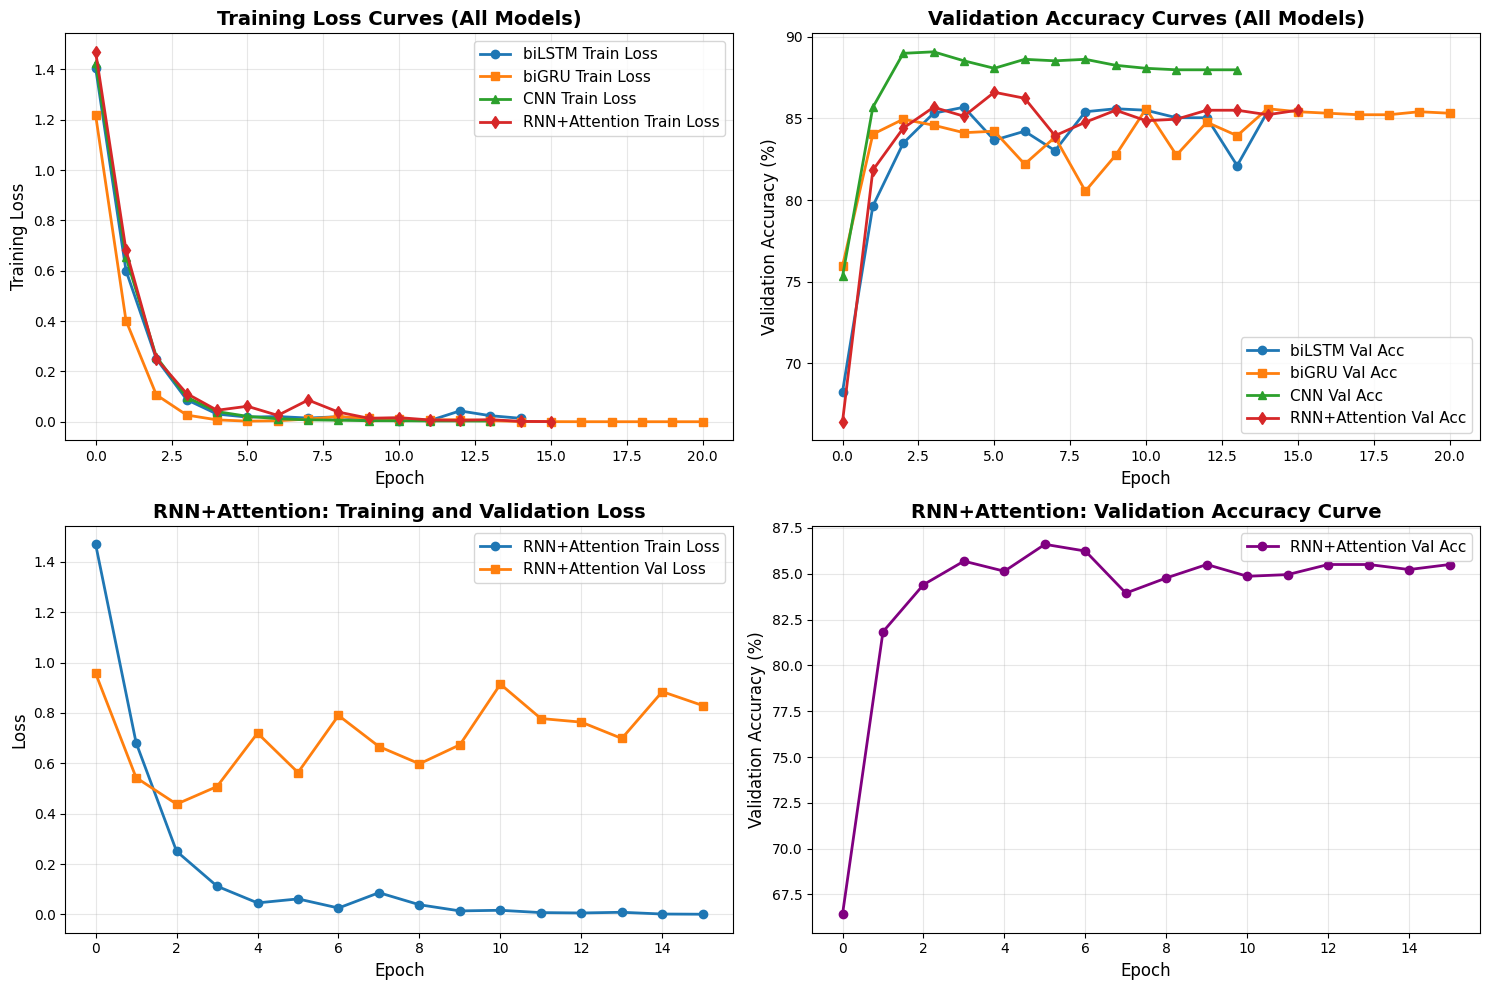

    Saved Part 3.3 curves to 'part3_3_training_curves.png'


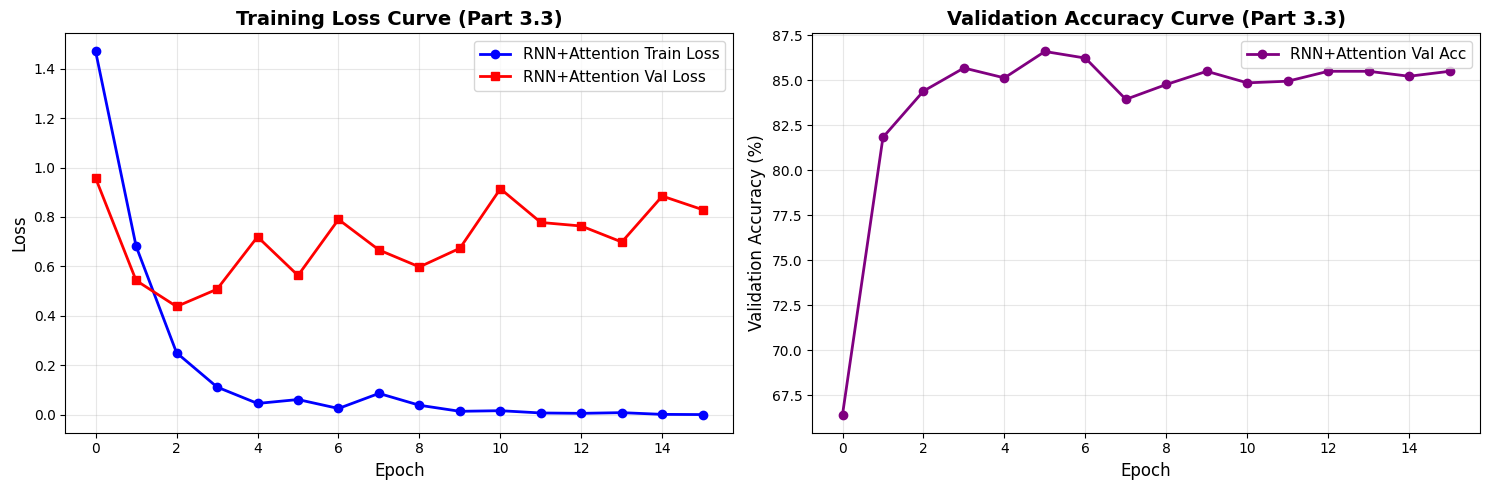


>>> Training curves plotted and saved for RNN + Attention model


In [73]:
# ============================================================================
# Plot Training Curves for RNN + Attention
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES - RNN + ATTENTION")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss Curves (Comparison: biLSTM, biGRU, CNN, RNN+Attention)
axes[0, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='s', linewidth=2)
axes[0, 0].plot(cnn_history['train_losses'], label='CNN Train Loss', marker='^', linewidth=2)
axes[0, 0].plot(rnn_attn_history['train_losses'], label='RNN+Attention Train Loss', marker='d', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Curves (All Models)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Curves (Comparison: biLSTM, biGRU, CNN, RNN+Attention)
axes[0, 1].plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM Val Acc', marker='o', linewidth=2)
axes[0, 1].plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU Val Acc', marker='s', linewidth=2)
axes[0, 1].plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='^', linewidth=2)
axes[0, 1].plot([acc*100 for acc in rnn_attn_history['val_accs']], label='RNN+Attention Val Acc', marker='d', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Validation Accuracy Curves (All Models)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: RNN+Attention Training and Validation Loss
axes[1, 0].plot(rnn_attn_history['train_losses'], label='RNN+Attention Train Loss', marker='o', linewidth=2)
axes[1, 0].plot(rnn_attn_history['val_losses'], label='RNN+Attention Val Loss', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('RNN+Attention: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: RNN+Attention Validation Accuracy
axes[1, 1].plot([acc*100 for acc in rnn_attn_history['val_accs']], label='RNN+Attention Val Acc', marker='o', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[1, 1].set_title('RNN+Attention: Validation Accuracy Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_rnn_attention_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_3_rnn_attention_training_curves.png'")
plt.show()  # Display the plot in notebook

# Also create separate plots for Part 3.3 requirement (training loss and validation accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(rnn_attn_history['train_losses'], label='RNN+Attention Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(rnn_attn_history['val_losses'], label='RNN+Attention Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (Part 3.3)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in rnn_attn_history['val_accs']], label='RNN+Attention Val Acc', marker='o', linewidth=2, color='purple')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (Part 3.3)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.3 curves to 'part3_3_training_curves.png'")
plt.show()  # Display the plot in notebook

print("\n>>> Training curves plotted and saved for RNN + Attention model")



In [74]:
# ============================================================================
# Part 3.3: CNN + BiLSTM + Attention Model
# ============================================================================
# Hybrid model combining CNN, BiLSTM, and Attention mechanisms

print("\n" + "="*80)
print("PART 3.3: CNN + biLSTM + ATTENTION MODEL")
print("="*80)

class CNNBiLSTMAttentionClassifier(nn.Module):
    """
    Hybrid model combining:
    - CNN: Extracts n-gram features with multiple filter sizes
    - BiLSTM: Captures sequential dependencies in both directions
    - Attention: Focuses on important parts of the sequence
    """
    def __init__(self, vocab_size, embedding_dim, output_dim, 
                 num_filters=100, filter_sizes=[3, 4, 5],
                 hidden_dim=256, n_layers=2, dropout=0.5,
                 padding_idx=0, pretrained_embeddings=None,
                 attention_dim=None):
        super(CNNBiLSTMAttentionClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.attention_dim = attention_dim if attention_dim else hidden_dim
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # CNN layers to extract n-gram features
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=filter_size,
                padding=filter_size // 2
            )
            for filter_size in filter_sizes
        ])
        
        # Bidirectional LSTM to capture sequential dependencies
        # Input size: num_filters * len(filter_sizes) (concatenated CNN features)
        self.bilstm = nn.LSTM(
            num_filters * len(filter_sizes),
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Additive Attention Mechanism (Bahdanau-style)
        # Attention over BiLSTM outputs
        self.attention_linear1 = nn.Linear(hidden_dim * 2, self.attention_dim)  # *2 for bidirectional
        self.attention_linear2 = nn.Linear(self.attention_dim, 1)
        self.tanh = nn.Tanh()
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        # Input: hidden_dim * 2 (bidirectional) after attention
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Step 1: Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Step 2: Apply CNN to extract n-gram features
        # CNN expects [batch_size, channels, seq_len]
        embedded_cnn = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        conv_outputs = []
        for conv in self.convs:
            # Convolution: [batch_size, num_filters, seq_len]
            conv_out = conv(embedded_cnn)
            conv_out = torch.relu(conv_out)
            conv_outputs.append(conv_out)
        
        # Concatenate CNN features from all filter sizes
        # [batch_size, num_filters * len(filter_sizes), seq_len]
        cnn_features = torch.cat(conv_outputs, dim=1)
        
        # Transpose back to [batch_size, seq_len, num_filters * len(filter_sizes)]
        cnn_features = cnn_features.permute(0, 2, 1)
        
        # Step 3: Pass through BiLSTM
        # Pack sequences for efficient processing
        packed_cnn = nn.utils.rnn.pack_padded_sequence(
            cnn_features, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        packed_output, (hidden, cell) = self.bilstm(packed_cnn)
        
        # Unpack sequences
        bilstm_output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # bilstm_output: [batch_size, seq_len, hidden_dim * 2]
        
        # Step 4: Apply Attention Mechanism
        # Compute attention scores using feed-forward network
        attention_scores = self.attention_linear1(bilstm_output)  # [batch_size, seq_len, attention_dim]
        attention_scores = self.tanh(attention_scores)
        attention_scores = self.attention_linear2(attention_scores).squeeze(2)  # [batch_size, seq_len]
        
        # Mask padding positions
        batch_size, seq_len = bilstm_output.size(0), bilstm_output.size(1)
        mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths.unsqueeze(1)
        attention_scores = attention_scores.masked_fill(~mask, float('-inf'))
        
        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, seq_len, 1]
        
        # Compute weighted sum of BiLSTM outputs
        context_vector = torch.sum(attention_weights * bilstm_output, dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Step 5: Pass through fully connected layer
        output = self.fc(context_vector)  # [batch_size, output_dim]
        
        return output

print(">>> CNNBiLSTMAttentionClassifier model class created")
print("    - Combines CNN (n-gram features), BiLSTM (sequential dependencies), and Attention")
print("    - CNN extracts local patterns, BiLSTM captures long-range dependencies")
print("    - Attention mechanism focuses on important parts of the sequence")




PART 3.3: CNN + biLSTM + ATTENTION MODEL
>>> CNNBiLSTMAttentionClassifier model class created
    - Combines CNN (n-gram features), BiLSTM (sequential dependencies), and Attention
    - CNN extracts local patterns, BiLSTM captures long-range dependencies
    - Attention mechanism focuses on important parts of the sequence


In [75]:
# ============================================================================
# Train CNN + BiLSTM + Attention Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING CNN + biLSTM + ATTENTION MODEL")
print("="*80)

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters for CNN + BiLSTM + Attention
HYBRID_NUM_FILTERS = 100
HYBRID_FILTER_SIZES = [3, 4, 5]
HYBRID_HIDDEN_DIM = 256  # Effective hidden size will be 512 (256*2) due to bidirectional
HYBRID_N_LAYERS = 2
HYBRID_DROPOUT = 0.5
HYBRID_BATCH_SIZE = 64
HYBRID_LEARNING_RATE = 0.001
HYBRID_N_EPOCHS = 100
HYBRID_PATIENCE = 10
HYBRID_ATTENTION_DIM = 256

# Create data iterators
train_iter_hybrid = data.BucketIterator(
    train_data,
    batch_size=HYBRID_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_hybrid = data.BucketIterator(
    validation_data,
    batch_size=HYBRID_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_hybrid = data.BucketIterator(
    test_data,
    batch_size=HYBRID_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create CNN + BiLSTM + Attention model
hybrid_model = CNNBiLSTMAttentionClassifier(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    output_dim=num_classes,
    num_filters=HYBRID_NUM_FILTERS,
    filter_sizes=HYBRID_FILTER_SIZES,
    hidden_dim=HYBRID_HIDDEN_DIM,
    n_layers=HYBRID_N_LAYERS,
    dropout=HYBRID_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    attention_dim=HYBRID_ATTENTION_DIM
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
hybrid_optimizer = optim.Adam(hybrid_model.parameters(), lr=HYBRID_LEARNING_RATE)

print(f"\n>>> CNN + BiLSTM + Attention Model Configuration:")
print(f"    CNN Filters: {HYBRID_NUM_FILTERS} per filter size")
print(f"    CNN Filter Sizes: {HYBRID_FILTER_SIZES}")
print(f"    BiLSTM Hidden Dim: {HYBRID_HIDDEN_DIM} (effective: {HYBRID_HIDDEN_DIM * 2} due to bidirectional)")
print(f"    BiLSTM Layers: {HYBRID_N_LAYERS}")
print(f"    Attention Dim: {HYBRID_ATTENTION_DIM}")
print(f"    Dropout: {HYBRID_DROPOUT}")
print(f"    Learning Rate: {HYBRID_LEARNING_RATE}")
print(f"    Batch Size: {HYBRID_BATCH_SIZE}")
print(f"    Max Epochs: {HYBRID_N_EPOCHS}, Patience: {HYBRID_PATIENCE}")

# Train hybrid model
hybrid_model, hybrid_history = train_model_with_history(
    hybrid_model, train_iter_hybrid, val_iter_hybrid, hybrid_optimizer, criterion,
    HYBRID_N_EPOCHS, device, patience=HYBRID_PATIENCE, model_name="CNN+BiLSTM+Attention"
)

# Save best model
torch.save(hybrid_model.state_dict(), 'weights/cnn_bilstm_attention_best.pt')
print(f"\n>>> CNN + BiLSTM + Attention model saved to 'weights/cnn_bilstm_attention_best.pt'")




TRAINING CNN + biLSTM + ATTENTION MODEL

>>> CNN + BiLSTM + Attention Model Configuration:
    CNN Filters: 100 per filter size
    CNN Filter Sizes: [3, 4, 5]
    BiLSTM Hidden Dim: 256 (effective: 512 due to bidirectional)
    BiLSTM Layers: 2
    Attention Dim: 256
    Dropout: 0.5
    Learning Rate: 0.001
    Batch Size: 64
    Max Epochs: 100, Patience: 10

>>> Training CNN+BiLSTM+Attention
    Parameters: 5,671,107
    Max epochs: 100, Patience: 10


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 9 for tensor number 1 in the list.

In [ ]:
# ============================================================================
# Evaluate CNN + BiLSTM + Attention Model on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - CNN + biLSTM + ATTENTION")
print("="*80)

# Evaluate hybrid model
print("\n>>> Evaluating CNN + BiLSTM + Attention on test set...")
hybrid_test_loss, hybrid_test_acc, hybrid_test_f1, hybrid_test_auc = evaluate_model(
    hybrid_model, test_iter_hybrid, criterion, device, "CNN+BiLSTM+Attention"
)

print(f"\n>>> CNN + BiLSTM + Attention Test Set Results:")
print(f"    Test Loss: {hybrid_test_loss:.4f}")
print(f"    Test Accuracy: {hybrid_test_acc*100:.2f}%")
print(f"    Test F1 Score: {hybrid_test_f1:.4f}")
print(f"    Test AUC-ROC: {hybrid_test_auc:.4f}")



In [ ]:
# ============================================================================
# Part 3.3 Updated Summary - All Models Including CNN + BiLSTM + Attention
# ============================================================================

print("\n" + "="*80)
print("PART 3.3 SUMMARY - ALL MODELS")
print("="*80)
print(f"{'Model':<20} {'Val Acc':<12} {'Val F1':<12} {'Val AUC':<12} {'Test Acc':<12} {'Test F1':<12} {'Test AUC':<12}")
print("-" * 100)
print(f"{'biLSTM':<20} {bilstm_history['best_val_acc']*100:<12.2f}% {bilstm_history['best_val_f1']:<12.4f} {bilstm_history['best_val_auc']:<12.4f} {bilstm_test_acc*100:<12.2f}% {bilstm_test_f1:<12.4f} {bilstm_test_auc:<12.4f}")
print(f"{'biGRU':<20} {bigru_history['best_val_acc']*100:<12.2f}% {bigru_history['best_val_f1']:<12.4f} {bigru_history['best_val_auc']:<12.4f} {bigru_test_acc*100:<12.2f}% {bigru_test_f1:<12.4f} {bigru_test_auc:<12.4f}")
print(f"{'CNN':<20} {cnn_history['best_val_acc']*100:<12.2f}% {cnn_history['best_val_f1']:<12.4f} {cnn_history['best_val_auc']:<12.4f} {cnn_test_acc*100:<12.2f}% {cnn_test_f1:<12.4f} {cnn_test_auc:<12.4f}")
print(f"{'RNN+Attention':<20} {rnn_attn_history['best_val_acc']*100:<12.2f}% {rnn_attn_history['best_val_f1']:<12.4f} {rnn_attn_history['best_val_auc']:<12.4f} {rnn_attn_test_acc*100:<12.2f}% {rnn_attn_test_f1:<12.4f} {rnn_attn_test_auc:<12.4f}")
print(f"{'CNN+BiLSTM+Attn':<20} {hybrid_history['best_val_acc']*100:<12.2f}% {hybrid_history['best_val_f1']:<12.4f} {hybrid_history['best_val_auc']:<12.4f} {hybrid_test_acc*100:<12.2f}% {hybrid_test_f1:<12.4f} {hybrid_test_auc:<12.4f}")
print("="*100)

# Find best model based on test accuracy
all_models_comparison = {
    'biLSTM': {
        'val_acc': bilstm_history['best_val_acc'],
        'val_f1': bilstm_history['best_val_f1'],
        'val_auc': bilstm_history['best_val_auc'],
        'test_acc': bilstm_test_acc,
        'test_f1': bilstm_test_f1,
        'test_auc': bilstm_test_auc
    },
    'biGRU': {
        'val_acc': bigru_history['best_val_acc'],
        'val_f1': bigru_history['best_val_f1'],
        'val_auc': bigru_history['best_val_auc'],
        'test_acc': bigru_test_acc,
        'test_f1': bigru_test_f1,
        'test_auc': bigru_test_auc
    },
    'CNN': {
        'val_acc': cnn_history['best_val_acc'],
        'val_f1': cnn_history['best_val_f1'],
        'val_auc': cnn_history['best_val_auc'],
        'test_acc': cnn_test_acc,
        'test_f1': cnn_test_f1,
        'test_auc': cnn_test_auc
    },
    'RNN+Attention': {
        'val_acc': rnn_attn_history['best_val_acc'],
        'val_f1': rnn_attn_history['best_val_f1'],
        'val_auc': rnn_attn_history['best_val_auc'],
        'test_acc': rnn_attn_test_acc,
        'test_f1': rnn_attn_test_f1,
        'test_auc': rnn_attn_test_auc
    },
    'CNN+BiLSTM+Attention': {
        'val_acc': hybrid_history['best_val_acc'],
        'val_f1': hybrid_history['best_val_f1'],
        'val_auc': hybrid_history['best_val_auc'],
        'test_acc': hybrid_test_acc,
        'test_f1': hybrid_test_f1,
        'test_auc': hybrid_test_auc
    }
}

best_model_test_acc = max(all_models_comparison.items(), key=lambda x: x[1]['test_acc'])
best_model_val_acc = max(all_models_comparison.items(), key=lambda x: x[1]['val_acc'])

print(f"\n>>> Best Model by Test Accuracy: {best_model_test_acc[0]}")
print(f"    Test Accuracy: {best_model_test_acc[1]['test_acc']*100:.2f}%")
print(f"    Test F1: {best_model_test_acc[1]['test_f1']:.4f}")
print(f"    Test AUC-ROC: {best_model_test_acc[1]['test_auc']:.4f}")

print(f"\n>>> Best Model by Validation Accuracy: {best_model_val_acc[0]}")
print(f"    Validation Accuracy: {best_model_val_acc[1]['val_acc']*100:.2f}%")
print(f"    Validation F1: {best_model_val_acc[1]['val_f1']:.4f}")
print(f"    Validation AUC-ROC: {best_model_val_acc[1]['val_auc']:.4f}")

print("\n>>> Part 3.3 Complete!")
print("    - RNN + Attention: Additive attention mechanism with bidirectional LSTM")
print("    - CNN + BiLSTM + Attention: Hybrid model combining CNN, BiLSTM, and attention")
print("    - All models compared above with validation and test metrics")
print("    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets")



In [ ]:
# ============================================================================
# Plot Training Curves for CNN + BiLSTM + Attention
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES - CNN + biLSTM + ATTENTION")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss Curves (All Models)
axes[0, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='s', linewidth=2)
axes[0, 0].plot(cnn_history['train_losses'], label='CNN Train Loss', marker='^', linewidth=2)
axes[0, 0].plot(rnn_attn_history['train_losses'], label='RNN+Attention Train Loss', marker='d', linewidth=2)
axes[0, 0].plot(hybrid_history['train_losses'], label='CNN+BiLSTM+Attn Train Loss', marker='*', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Curves (All Models)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Curves (All Models)
axes[0, 1].plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM Val Acc', marker='o', linewidth=2)
axes[0, 1].plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU Val Acc', marker='s', linewidth=2)
axes[0, 1].plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='^', linewidth=2)
axes[0, 1].plot([acc*100 for acc in rnn_attn_history['val_accs']], label='RNN+Attention Val Acc', marker='d', linewidth=2)
axes[0, 1].plot([acc*100 for acc in hybrid_history['val_accs']], label='CNN+BiLSTM+Attn Val Acc', marker='*', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Validation Accuracy Curves (All Models)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: CNN+BiLSTM+Attention Training and Validation Loss
axes[1, 0].plot(hybrid_history['train_losses'], label='CNN+BiLSTM+Attn Train Loss', marker='o', linewidth=2)
axes[1, 0].plot(hybrid_history['val_losses'], label='CNN+BiLSTM+Attn Val Loss', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('CNN+BiLSTM+Attention: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: CNN+BiLSTM+Attention Validation Accuracy
axes[1, 1].plot([acc*100 for acc in hybrid_history['val_accs']], label='CNN+BiLSTM+Attn Val Acc', marker='o', linewidth=2, color='orange')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[1, 1].set_title('CNN+BiLSTM+Attention: Validation Accuracy Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_cnn_bilstm_attention_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_3_cnn_bilstm_attention_training_curves.png'")
plt.show()  # Display the plot in notebook

# Also create separate plots for Part 3.3 requirement (training loss and validation accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(hybrid_history['train_losses'], label='CNN+BiLSTM+Attn Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(hybrid_history['val_losses'], label='CNN+BiLSTM+Attn Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (CNN+BiLSTM+Attention)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in hybrid_history['val_accs']], label='CNN+BiLSTM+Attn Val Acc', marker='o', linewidth=2, color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (CNN+BiLSTM+Attention)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_hybrid_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.3 hybrid curves to 'part3_3_hybrid_training_curves.png'")
plt.show()  # Display the plot in notebook

print("\n>>> Training curves plotted and saved for CNN + BiLSTM + Attention model")



In [ ]:
# ============================================================================
# Part 3.3: RNN + Pretrained BERT Model
# ============================================================================
# Hybrid model combining pretrained BERT embeddings with RNN

print("\n" + "="*80)
print("PART 3.3: RNN + PRETRAINED BERT MODEL")
print("="*80)

# Import transformers for BERT
try:
    from transformers import BertModel, BertTokenizer
    BERT_AVAILABLE = True
    print(">>> Transformers library available")
except ImportError:
    print(">>> Warning: transformers library not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers"])
    from transformers import BertModel, BertTokenizer
    BERT_AVAILABLE = True
    print(">>> Transformers library installed")

class RNNBertClassifier(nn.Module):
    """
    RNN with Pretrained BERT embeddings
    Uses BERT to get contextualized embeddings, then passes through BiLSTM with attention
    """
    def __init__(self, output_dim, hidden_dim=256, n_layers=2, dropout=0.5,
                 bert_model_name='bert-base-uncased', freeze_bert=False):
        super(RNNBertClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.freeze_bert = freeze_bert
        
        # Load pretrained BERT model and tokenizer
        self.bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        self.bert_model = BertModel.from_pretrained(bert_model_name)
        
        # Freeze BERT parameters if specified
        if freeze_bert:
            for param in self.bert_model.parameters():
                param.requires_grad = False
        
        # BERT output dimension (768 for bert-base-uncased)
        bert_output_dim = self.bert_model.config.hidden_size
        
        # Bidirectional LSTM to process BERT embeddings
        self.bilstm = nn.LSTM(
            bert_output_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Additive Attention Mechanism (Bahdanau-style)
        self.attention_linear1 = nn.Linear(hidden_dim * 2, hidden_dim)  # *2 for bidirectional
        self.attention_linear2 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths, text_vocab=None):
        # text: [batch_size, seq_len] - token indices from torchtext
        # text_lengths: [batch_size] - actual sequence lengths
        # text_vocab: TEXT.vocab.itos to convert indices to tokens
        
        batch_size = text.size(0)
        seq_len = text.size(1)
        device = text.device
        
        # Convert token indices back to text strings using vocab
        text_list = []
        for i in range(batch_size):
            actual_len = text_lengths[i].item() if isinstance(text_lengths[i], torch.Tensor) else text_lengths[i]
            tokens = []
            for j in range(min(actual_len, seq_len)):
                token_idx = text[i, j].item()
                if text_vocab is not None and token_idx < len(text_vocab):
                    token = text_vocab[token_idx]
                    # Skip special tokens
                    if token not in ['<pad>', '<unk>', '<sos>', '<eos>']:
                        tokens.append(token)
                else:
                    # Fallback if vocab not provided
                    tokens.append(str(token_idx))
            # Join tokens to form sentence
            sentence = " ".join(tokens)
            text_list.append(sentence)
        
        # Tokenize with BERT
        encoded = self.bert_tokenizer(
            text_list,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)
        
        # Get BERT embeddings
        with torch.set_grad_enabled(not self.freeze_bert):
            bert_outputs = self.bert_model(**encoded)
            bert_embeddings = bert_outputs.last_hidden_state  # [batch_size, seq_len, 768]
        
        # Get actual sequence lengths from BERT tokenizer
        bert_lengths = encoded['attention_mask'].sum(dim=1).cpu()
        
        # Pack sequences for efficient RNN processing
        packed_bert = nn.utils.rnn.pack_padded_sequence(
            bert_embeddings, bert_lengths, batch_first=True, enforce_sorted=False
        )
        
        # Pass through bidirectional LSTM
        packed_output, (hidden, cell) = self.bilstm(packed_bert)
        
        # Unpack sequences
        bilstm_output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # bilstm_output: [batch_size, seq_len, hidden_dim * 2]
        
        # Apply Attention Mechanism
        attention_scores = self.attention_linear1(bilstm_output)  # [batch_size, seq_len, hidden_dim]
        attention_scores = self.tanh(attention_scores)
        attention_scores = self.attention_linear2(attention_scores).squeeze(2)  # [batch_size, seq_len]
        
        # Mask padding positions
        batch_size_attn, seq_len_attn = bilstm_output.size(0), bilstm_output.size(1)
        mask = torch.arange(seq_len_attn, device=device).unsqueeze(0) < bert_lengths.unsqueeze(1).to(device)
        attention_scores = attention_scores.masked_fill(~mask, float('-inf'))
        
        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, seq_len, 1]
        
        # Compute weighted sum
        context_vector = torch.sum(attention_weights * bilstm_output, dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Pass through fully connected layer
        output = self.fc(context_vector)  # [batch_size, output_dim]
        
        return output

print(">>> RNNBertClassifier model class created")
print("    - Uses pretrained BERT (bert-base-uncased) for contextualized embeddings")
print("    - Passes BERT embeddings through bidirectional LSTM")
print("    - Applies attention mechanism to focus on important parts")



In [ ]:
# Helper function to process batch for BERT model
def process_batch_bert(batch, text_vocab, debug=False):
    """
    Process batch for BERT model - converts token indices to strings
    """
    text, text_lengths = batch.text
    labels = batch.label
    
    # Convert to proper format
    if isinstance(text, tuple):
        text, text_lengths = text
    
    # Ensure text_lengths is 1D
    if text_lengths.dim() > 1:
        text_lengths = text_lengths.squeeze()
    
    text = text.to(device)
    text_lengths = text_lengths.to(device)
    labels = labels.to(device)
    
    if debug:
        print(f"DEBUG BERT BATCH - text shape: {text.shape}, text_lengths shape: {text_lengths.shape}, labels shape: {labels.shape}")
    
    return text, text_lengths, labels, text_vocab

print(">>> Helper function process_batch_bert created")



In [ ]:
# ============================================================================
# Train RNN + BERT Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING RNN + BERT MODEL")
print("="*80)

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters for RNN + BERT
BERT_HIDDEN_DIM = 256  # Effective hidden size will be 512 (256*2) due to bidirectional
BERT_N_LAYERS = 2
BERT_DROPOUT = 0.5
BERT_BATCH_SIZE = 32  # Smaller batch size due to BERT's memory requirements
BERT_LEARNING_RATE = 2e-5  # Lower learning rate for fine-tuning BERT
BERT_N_EPOCHS = 50  # Fewer epochs as BERT converges faster
BERT_PATIENCE = 7
BERT_FREEZE = False  # Fine-tune BERT (set to True to freeze BERT)

# Create data iterators
train_iter_bert = data.BucketIterator(
    train_data,
    batch_size=BERT_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_bert = data.BucketIterator(
    validation_data,
    batch_size=BERT_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_bert = data.BucketIterator(
    test_data,
    batch_size=BERT_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create RNN + BERT model
bert_model = RNNBertClassifier(
    output_dim=num_classes,
    hidden_dim=BERT_HIDDEN_DIM,
    n_layers=BERT_N_LAYERS,
    dropout=BERT_DROPOUT,
    bert_model_name='bert-base-uncased',
    freeze_bert=BERT_FREEZE
).to(device)

# Loss function and optimizer
# Use different learning rates for BERT and other layers
bert_params = list(bert_model.bert_model.parameters())
other_params = [p for n, p in bert_model.named_parameters() if 'bert_model' not in n]

bert_optimizer = optim.AdamW([
    {'params': bert_params, 'lr': BERT_LEARNING_RATE},
    {'params': other_params, 'lr': BERT_LEARNING_RATE * 10}  # Higher LR for new layers
], weight_decay=0.01)

print(f"\n>>> RNN + BERT Model Configuration:")
print(f"    BERT Model: bert-base-uncased")
print(f"    BERT Frozen: {BERT_FREEZE}")
print(f"    BiLSTM Hidden Dim: {BERT_HIDDEN_DIM} (effective: {BERT_HIDDEN_DIM * 2} due to bidirectional)")
print(f"    BiLSTM Layers: {BERT_N_LAYERS}")
print(f"    Dropout: {BERT_DROPOUT}")
print(f"    Learning Rate: {BERT_LEARNING_RATE} (BERT), {BERT_LEARNING_RATE * 10} (other layers)")
print(f"    Batch Size: {BERT_BATCH_SIZE}")
print(f"    Max Epochs: {BERT_N_EPOCHS}, Patience: {BERT_PATIENCE}")

# Modified training function for BERT
def train_model_with_history_bert(model, train_iterator, val_iterator, optimizer, criterion, 
                                   n_epochs, device, patience=10, model_name="model", text_vocab=None):
    """
    Train the model with early stopping and track training history (BERT version)
    """
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_val_auc = 0.0
    patience_counter = 0
    best_model_state = None
    
    # History tracking
    train_losses = []
    val_losses = []
    val_accs = []
    val_f1s = []
    val_aucs = []
    
    print(f"\n>>> Training {model_name}")
    print(f"    Parameters: {count_parameters(model):,}")
    print(f"    Max epochs: {n_epochs}, Patience: {patience}")
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iterator:
            text, text_lengths, labels, _ = process_batch_bert(batch, text_vocab, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths, text_vocab=text_vocab)
            loss = criterion(predictions, labels)
            loss.backward()
            # Gradient clipping for BERT
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_iterator)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        val_probs = []
        
        with torch.no_grad():
            for batch in val_iterator:
                text, text_lengths, labels, _ = process_batch_bert(batch, text_vocab, debug=False)
                predictions = model(text, text_lengths, text_vocab=text_vocab)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                probs = torch.softmax(predictions, dim=1)
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_iterator)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        # Calculate AUC-ROC
        try:
            val_probs_array = np.array(val_probs)
            val_labels_bin = label_binarize(val_labels, classes=range(num_classes))
            val_auc = roc_auc_score(val_labels_bin, val_probs_array, average='weighted', multi_class='ovr')
        except Exception as e:
            print(f"Warning: Could not calculate AUC-ROC for {model_name} at epoch {epoch+1}: {e}")
            val_auc = 0.0
        
        # Store history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
        
        # Early stopping and model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_val_auc = val_auc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        print(f'Epoch: {epoch+1:02}/{n_epochs} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
        print(f'\tTrain Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}')
        
        if patience_counter >= patience:
            print(f'\t>>> Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%')
            break
    
    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f'\n>>> Training completed! Best validation accuracy: {best_val_acc*100:.2f}%')
    print(f'    Best validation F1: {best_val_f1:.4f}')
    print(f'    Best validation AUC-ROC: {best_val_auc:.4f}')
    
    # Return history dictionary
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'val_f1s': val_f1s,
        'val_aucs': val_aucs,
        'best_val_acc': best_val_acc,
        'best_val_f1': best_val_f1,
        'best_val_auc': best_val_auc,
        'epochs_trained': len(train_losses)
    }
    
    return model, history

# Train RNN + BERT model
bert_model, bert_history = train_model_with_history_bert(
    bert_model, train_iter_bert, val_iter_bert, bert_optimizer, criterion,
    BERT_N_EPOCHS, device, patience=BERT_PATIENCE, model_name="RNN+BERT", text_vocab=TEXT.vocab.itos
)

# Save best model
torch.save(bert_model.state_dict(), 'weights/rnn_bert_best.pt')
print(f"\n>>> RNN + BERT model saved to 'weights/rnn_bert_best.pt'")



In [ ]:
# ============================================================================
# Evaluate RNN + BERT Model on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - RNN + BERT")
print("="*80)

# Modified evaluate function for BERT
def evaluate_model_bert(model, iterator, criterion, device, model_name, text_vocab=None):
    """Evaluate model on test set and return metrics (BERT version)"""
    model.eval()
    test_loss = 0
    test_preds = []
    test_labels = []
    test_probs = []
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths, labels, _ = process_batch_bert(batch, text_vocab, debug=False)
            predictions = model(text, text_lengths, text_vocab=text_vocab)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            probs = torch.softmax(predictions, dim=1)
            preds = torch.argmax(predictions, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
    
    avg_test_loss = test_loss / len(iterator)
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    
    # Calculate AUC-ROC
    try:
        test_probs_array = np.array(test_probs)
        test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
        test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
    except Exception as e:
        print(f"Warning: Could not calculate AUC-ROC for {model_name}: {e}")
        test_auc = 0.0
    
    return avg_test_loss, test_acc, test_f1, test_auc

# Evaluate RNN + BERT
print("\n>>> Evaluating RNN + BERT on test set...")
bert_test_loss, bert_test_acc, bert_test_f1, bert_test_auc = evaluate_model_bert(
    bert_model, test_iter_bert, criterion, device, "RNN+BERT", text_vocab=TEXT.vocab.itos
)

print(f"\n>>> RNN + BERT Test Set Results:")
print(f"    Test Loss: {bert_test_loss:.4f}")
print(f"    Test Accuracy: {bert_test_acc*100:.2f}%")
print(f"    Test F1 Score: {bert_test_f1:.4f}")
print(f"    Test AUC-ROC: {bert_test_auc:.4f}")



In [ ]:
# ============================================================================
# Part 3.3 Final Summary - All Models Including RNN + BERT
# ============================================================================

print("\n" + "="*80)
print("PART 3.3 FINAL SUMMARY - ALL MODELS")
print("="*80)
print(f"{'Model':<20} {'Val Acc':<12} {'Val F1':<12} {'Val AUC':<12} {'Test Acc':<12} {'Test F1':<12} {'Test AUC':<12}")
print("-" * 100)
print(f"{'biLSTM':<20} {bilstm_history['best_val_acc']*100:<12.2f}% {bilstm_history['best_val_f1']:<12.4f} {bilstm_history['best_val_auc']:<12.4f} {bilstm_test_acc*100:<12.2f}% {bilstm_test_f1:<12.4f} {bilstm_test_auc:<12.4f}")
print(f"{'biGRU':<20} {bigru_history['best_val_acc']*100:<12.2f}% {bigru_history['best_val_f1']:<12.4f} {bigru_history['best_val_auc']:<12.4f} {bigru_test_acc*100:<12.2f}% {bigru_test_f1:<12.4f} {bigru_test_auc:<12.4f}")
print(f"{'CNN':<20} {cnn_history['best_val_acc']*100:<12.2f}% {cnn_history['best_val_f1']:<12.4f} {cnn_history['best_val_auc']:<12.4f} {cnn_test_acc*100:<12.2f}% {cnn_test_f1:<12.4f} {cnn_test_auc:<12.4f}")
print(f"{'RNN+Attention':<20} {rnn_attn_history['best_val_acc']*100:<12.2f}% {rnn_attn_history['best_val_f1']:<12.4f} {rnn_attn_history['best_val_auc']:<12.4f} {rnn_attn_test_acc*100:<12.2f}% {rnn_attn_test_f1:<12.4f} {rnn_attn_test_auc:<12.4f}")
print(f"{'CNN+BiLSTM+Attn':<20} {hybrid_history['best_val_acc']*100:<12.2f}% {hybrid_history['best_val_f1']:<12.4f} {hybrid_history['best_val_auc']:<12.4f} {hybrid_test_acc*100:<12.2f}% {hybrid_test_f1:<12.4f} {hybrid_test_auc:<12.4f}")
print(f"{'RNN+BERT':<20} {bert_history['best_val_acc']*100:<12.2f}% {bert_history['best_val_f1']:<12.4f} {bert_history['best_val_auc']:<12.4f} {bert_test_acc*100:<12.2f}% {bert_test_f1:<12.4f} {bert_test_auc:<12.4f}")
print("="*100)

# Find best model based on test accuracy
all_models_final = {
    'biLSTM': {
        'val_acc': bilstm_history['best_val_acc'],
        'val_f1': bilstm_history['best_val_f1'],
        'val_auc': bilstm_history['best_val_auc'],
        'test_acc': bilstm_test_acc,
        'test_f1': bilstm_test_f1,
        'test_auc': bilstm_test_auc
    },
    'biGRU': {
        'val_acc': bigru_history['best_val_acc'],
        'val_f1': bigru_history['best_val_f1'],
        'val_auc': bigru_history['best_val_auc'],
        'test_acc': bigru_test_acc,
        'test_f1': bigru_test_f1,
        'test_auc': bigru_test_auc
    },
    'CNN': {
        'val_acc': cnn_history['best_val_acc'],
        'val_f1': cnn_history['best_val_f1'],
        'val_auc': cnn_history['best_val_auc'],
        'test_acc': cnn_test_acc,
        'test_f1': cnn_test_f1,
        'test_auc': cnn_test_auc
    },
    'RNN+Attention': {
        'val_acc': rnn_attn_history['best_val_acc'],
        'val_f1': rnn_attn_history['best_val_f1'],
        'val_auc': rnn_attn_history['best_val_auc'],
        'test_acc': rnn_attn_test_acc,
        'test_f1': rnn_attn_test_f1,
        'test_auc': rnn_attn_test_auc
    },
    'CNN+BiLSTM+Attention': {
        'val_acc': hybrid_history['best_val_acc'],
        'val_f1': hybrid_history['best_val_f1'],
        'val_auc': hybrid_history['best_val_auc'],
        'test_acc': hybrid_test_acc,
        'test_f1': hybrid_test_f1,
        'test_auc': hybrid_test_auc
    },
    'RNN+BERT': {
        'val_acc': bert_history['best_val_acc'],
        'val_f1': bert_history['best_val_f1'],
        'val_auc': bert_history['best_val_auc'],
        'test_acc': bert_test_acc,
        'test_f1': bert_test_f1,
        'test_auc': bert_test_auc
    }
}

best_model_test_acc = max(all_models_final.items(), key=lambda x: x[1]['test_acc'])
best_model_val_acc = max(all_models_final.items(), key=lambda x: x[1]['val_acc'])

print(f"\n>>> Best Model by Test Accuracy: {best_model_test_acc[0]}")
print(f"    Test Accuracy: {best_model_test_acc[1]['test_acc']*100:.2f}%")
print(f"    Test F1: {best_model_test_acc[1]['test_f1']:.4f}")
print(f"    Test AUC-ROC: {best_model_test_acc[1]['test_auc']:.4f}")

print(f"\n>>> Best Model by Validation Accuracy: {best_model_val_acc[0]}")
print(f"    Validation Accuracy: {best_model_val_acc[1]['val_acc']*100:.2f}%")
print(f"    Validation F1: {best_model_val_acc[1]['val_f1']:.4f}")
print(f"    Validation AUC-ROC: {best_model_val_acc[1]['val_auc']:.4f}")

print("\n>>> Part 3.3 Complete!")
print("    - RNN + Attention: Additive attention mechanism with bidirectional LSTM")
print("    - CNN + BiLSTM + Attention: Hybrid model combining CNN, BiLSTM, and attention")
print("    - RNN + BERT: Pretrained BERT embeddings with bidirectional LSTM and attention")
print("    - All models compared above with validation and test metrics")
print("    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets")



In [ ]:
# ============================================================================
# Plot Training Curves for RNN + BERT
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES - RNN + BERT")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss Curves (All Models)
axes[0, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='s', linewidth=2)
axes[0, 0].plot(cnn_history['train_losses'], label='CNN Train Loss', marker='^', linewidth=2)
axes[0, 0].plot(rnn_attn_history['train_losses'], label='RNN+Attention Train Loss', marker='d', linewidth=2)
axes[0, 0].plot(hybrid_history['train_losses'], label='CNN+BiLSTM+Attn Train Loss', marker='*', linewidth=2)
axes[0, 0].plot(bert_history['train_losses'], label='RNN+BERT Train Loss', marker='x', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Curves (All Models)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Curves (All Models)
axes[0, 1].plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM Val Acc', marker='o', linewidth=2)
axes[0, 1].plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU Val Acc', marker='s', linewidth=2)
axes[0, 1].plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='^', linewidth=2)
axes[0, 1].plot([acc*100 for acc in rnn_attn_history['val_accs']], label='RNN+Attention Val Acc', marker='d', linewidth=2)
axes[0, 1].plot([acc*100 for acc in hybrid_history['val_accs']], label='CNN+BiLSTM+Attn Val Acc', marker='*', linewidth=2)
axes[0, 1].plot([acc*100 for acc in bert_history['val_accs']], label='RNN+BERT Val Acc', marker='x', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Validation Accuracy Curves (All Models)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: RNN+BERT Training and Validation Loss
axes[1, 0].plot(bert_history['train_losses'], label='RNN+BERT Train Loss', marker='o', linewidth=2)
axes[1, 0].plot(bert_history['val_losses'], label='RNN+BERT Val Loss', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('RNN+BERT: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: RNN+BERT Validation Accuracy
axes[1, 1].plot([acc*100 for acc in bert_history['val_accs']], label='RNN+BERT Val Acc', marker='o', linewidth=2, color='brown')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[1, 1].set_title('RNN+BERT: Validation Accuracy Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_rnn_bert_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_3_rnn_bert_training_curves.png'")
plt.show()  # Display the plot in notebook

# Also create separate plots for Part 3.3 requirement (training loss and validation accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(bert_history['train_losses'], label='RNN+BERT Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(bert_history['val_losses'], label='RNN+BERT Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (RNN+BERT)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in bert_history['val_accs']], label='RNN+BERT Val Acc', marker='o', linewidth=2, color='brown')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (RNN+BERT)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_3_bert_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.3 BERT curves to 'part3_3_bert_training_curves.png'")
plt.show()  # Display the plot in notebook

print("\n>>> Training curves plotted and saved for RNN + BERT model")



In [ ]:
# c) 

1: (hybrid model) rnn + attention layer
2: (hybrid model) cnn + bilstm + attention layer
3: (hybrid model) bigru + pretrained transformer (berto)